# Book- Crossing recomender system 

## Abstract: 
The objective of this project is to develop a recommender application using the BookCrossing dataset collected by Cai-Nicolas Ziegler. The outcome of this system makes predictions utilizing the dataset that is up for cleaning and analysis. This accurately foresees the users’ preferences of the books they read to that of others based on demographic, content, and ratings.

## Ethical ML Framework
The purpose of this framework is to establish a set of standards prior to developing a book recommender system and undertake any scenario or dataset values. However, since the BookCrossing dataset has an open platform and collected with demographic information, many of the ethical ML framework principles do not apply. The website carrying this dataset does state the following message: “Freely available for research use when acknowledged with the following reference.” This implies that Cai-Nicolas Ziegler wants its users to acknowledge the research group one is partaking in and the publications that may result from using the BookCrossing dataset. Therefore depending on the scenario and impact of the application, there would be more stricter measures in appropriating the techniques utilized for this project.

### Importing the libraraies and the datasets

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import seaborn as sns
#from sklearn import model_selection
from surprise import Reader, Dataset
from surprise import model_selection, accuracy
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import CoClustering
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline



warnings.filterwarnings('ignore') # Turn off warnings
plt.style.use('seaborn-white') # Use seaborn-style plots
plt.rcParams.update({'font.size': 15}) # Set larger default plot font size
%matplotlib inline





**The data set was downlaoded from** "http://www2.informatik.uni-freiburg.de/~cziegler/BX/ " and it is consisted of 3 files 
1- Users Data
2- Books Data
3- Books Ratings
Below is the data imported

In [2]:
users = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/users.csv", sep=';', encoding='ansi')
books = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/Books.csv", sep=';', encoding='ansi', escapechar='\\')
ratings = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/Book-Ratings.csv", sep=';', encoding='ansi')


In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


## Exploring the data sets

In [6]:
#checking the types of data in each data set
dtBooks = books.dtypes
dtratings = ratings.dtypes
dtusers = users.dtypes

print(dtBooks)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [7]:
print(dtratings)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [8]:
print(dtusers)

User-ID       int64
Location     object
Age         float64
dtype: object


In [9]:
books.info()
books.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


,Year-Of-Publication
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [10]:
ratings.info()
ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [11]:
users.columns = ['User_id',"Location","Age"]
users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User_id   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


,User_id,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [12]:
users.isna().sum()
users.isnull().sum()

User_id          0
Location         0
Age         110762
dtype: int64

In [13]:
ratings.isna().sum()
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [14]:
books.isna().sum()
#books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

## Discovery of the users data set 

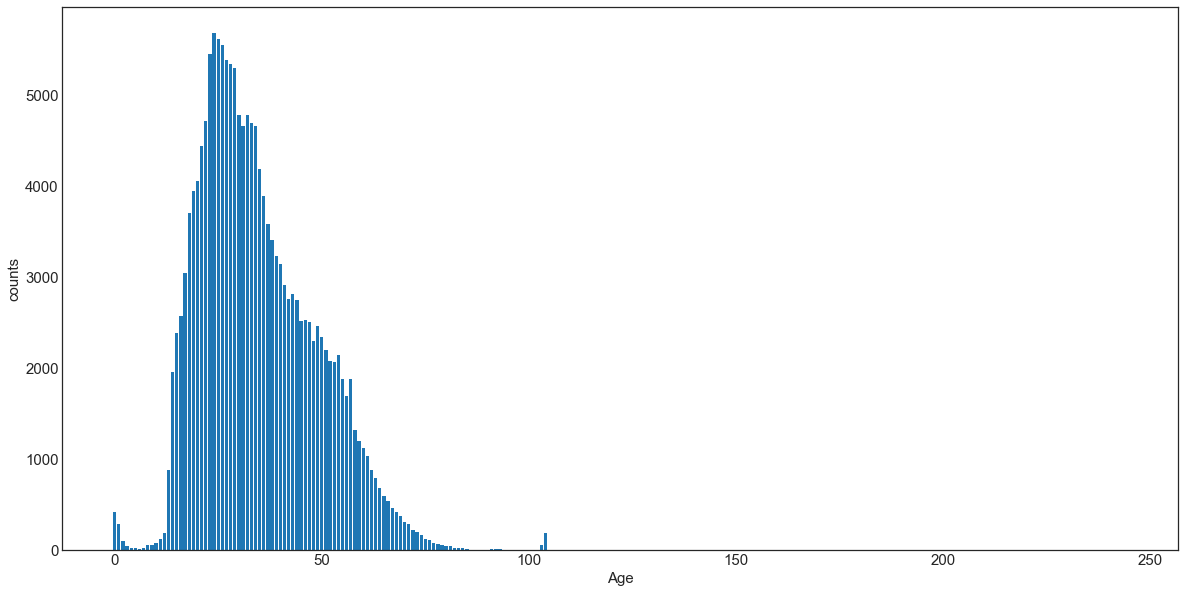

In [15]:
u = users.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

From the above graph it seems that there are some oult liares as some users age is more than 100 and less than 10 years old
So We will be cleaning users data set by changing all the values less tha more than 100 and less than 5 years old to na

In [16]:
users.loc[(users.Age<5) | (users.Age>100), 'Age'] = np.nan
users1 = pd.DataFrame(users)



In [17]:
print(sorted(users1.Age.unique()))

[nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


In [18]:
#40% of the users does not have age value which is a big number so we will try to fill all the na values with the same distribution of age 
users1.Age.isnull().sum() / len(users)

0.4016739702644357

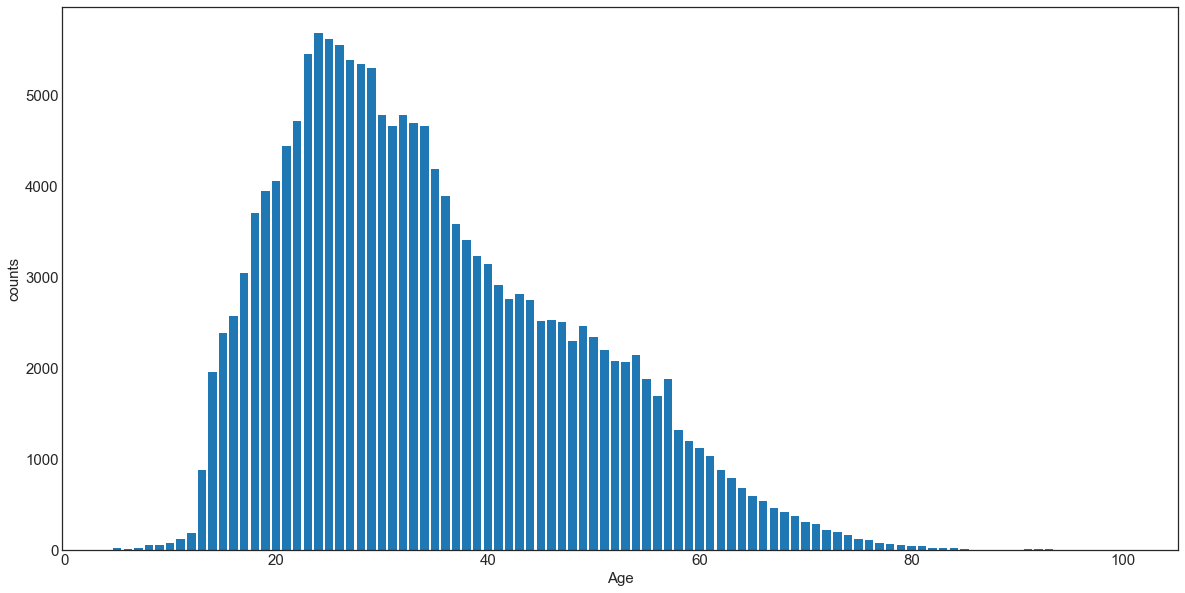

In [19]:
u = users1.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

In [20]:
users1.Age.fillna(users1.Age.mean()).describe()

count    278858.000000
mean         34.746638
std          10.545361
min           5.000000
25%          29.000000
50%          34.746638
75%          35.000000
max         100.000000
Name: Age, dtype: float64

In [21]:
# create a normal disrtribution pd.Series to fill Nan values with
temp_age_series = pd.Series(np.random.normal(loc=users1.Age.mean(), scale=users1.Age.std(), size=users1.User_id[users1.Age.isna()].count()))
print("Describtion of the user1 dataset age") 
print(users1.Age.describe())
print("Describtion of the Age series")
print(temp_age_series.describe())
print("checking the negative values in the distribution series")
print(temp_age_series[temp_age_series<0].count())


#As we can see the destribution doesnt change a lot. There are some negative values which we will take only the absulate values for the age distribution 




Describtion of the user1 dataset age
count    166848.000000
mean         34.746638
std          13.633051
min           5.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         100.000000
Name: Age, dtype: float64
Describtion of the Age series
count    112010.000000
mean         34.772346
std          13.631266
min         -22.405237
25%          25.525435
50%          34.821120
75%          44.011419
max          96.199089
dtype: float64
checking the negative values in the distribution series
627


In [22]:
# take the abs value of temp_Age_series
pos_age_series=np.abs(temp_age_series)

# sort users1 Df so as NaN values in Age to be first and reset index to match with index of pos_Age_series. Then use fillna()
users1 = users1.sort_values('Age',na_position='first').reset_index(drop=True)
users1.Age.fillna(pos_age_series, inplace = True)
users1.loc[users1.Age<5, 'Age'] = users1.Age.mean()
users1.Age = users1.Age.round().astype(int)

#Sort users1 based on User-ID so as to be the same as before
users1 = users1.sort_values('User_id').reset_index(drop=True)
print(users1.Age.describe(),"\n")
users1.head()


count    278858.000000
mean         34.944072
std          13.385558
min           5.000000
25%          25.000000
50%          33.000000
75%          44.000000
max         100.000000
Name: Age, dtype: float64 



,User_id,Location,Age
0,1,"nyc, new york, usa",27
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",60
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",40


As we can see the destribution doesnt change a lot. There are some negative values which we will take only the absulate values for the age distribution 

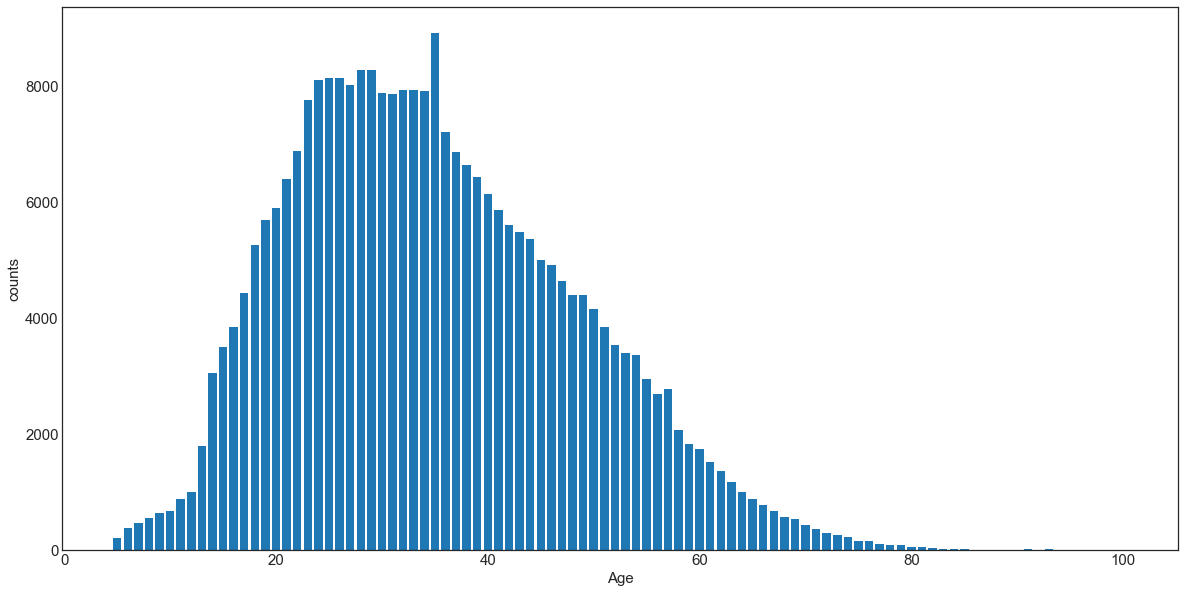

0.0

In [23]:
u = users1.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

users1.Age.isnull().sum() / len(users)

### Exploring the countries of users

In [24]:
#users.Location.str.split(",")
#users[["City", "State", "Country"]] = users.Location.str.split(",", expand=True)

split_data = users1["Location"].str.split(",",2,expand=True)
split_data.columns = ["City", "State", "Country"]
users2 = users1.join(split_data)
del users2["Location"]

print(users2)




        User_id  Age         City             State          Country
0             1   27          nyc          new york              usa
1             2   18     stockton        california              usa
2             3   60       moscow   yukon territory           russia
3             4   17        porto          v.n.gaia         portugal
4             5   40  farnborough             hants   united kingdom
...         ...  ...          ...               ...              ...
278853   278854    7     portland            oregon              usa
278854   278855   50       tacoma        washington   united kingdom
278855   278856   39     brampton           ontario           canada
278856   278857   55    knoxville         tennessee              usa
278857   278858   45       dublin               n/a          ireland

[278858 rows x 5 columns]


In [25]:
users2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User_id  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278857 non-null  object
 4   Country  278856 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


In [26]:
users2['City'].value_counts().sort_values(ascending=False)

london                4105
barcelona             2664
toronto               2342
madrid                1933
sydney                1884
                      ... 
anagni                   1
s.vicente ferreira       1
bogota d.c.              1
bosch en duin            1
vechelde                 1
Name: City, Length: 32770, dtype: int64

In [27]:
users2['Country'].value_counts()

 usa                  139183
 canada                21556
 united kingdom        18286
 germany               17021
 spain                 13088
                       ...  
 swazilandia               1
 baden-württemberg         1
, malaysia                 1
 , australia               1
 pinallas                  1
Name: Country, Length: 1276, dtype: int64

**Based on the values missing We will use the City for the analysis of the users and we will drop the Country and the State as most of the countries does not have states.**

In [28]:
print((users2["City"].values == '').sum())
print((users2["City"].isnull().sum()))

122
0


In [29]:
nan_value = float("NaN")
users2.replace("", nan_value, inplace=True)
users2.dropna(subset = ["City"], inplace=True)

In [30]:
print((users2["City"].values == '').sum())
print((users2["City"].isnull().sum()))

0
0


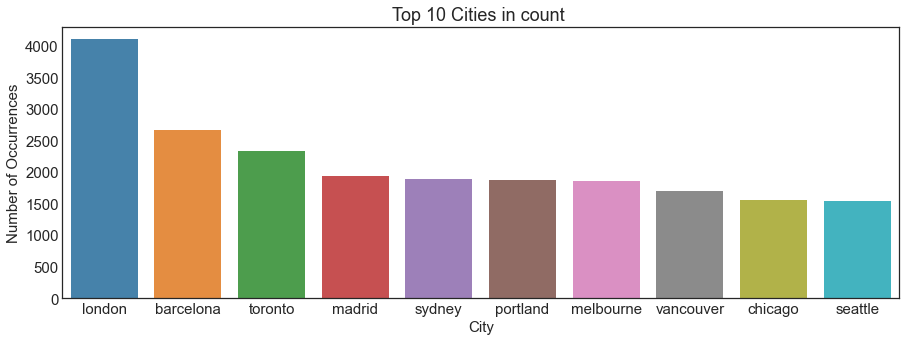

In [31]:
city_count  = users2["City"].value_counts()
city_count = city_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(city_count.index, city_count.values, alpha=0.9)
plt.title('Top 10 Cities in count ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('City', fontsize=15)
plt.show()

The chart above highlights the total number of readers per each city; where London, England ranks topmost in terms of majority of readers, followed by Barcelona, Spain and Toronto, Canada

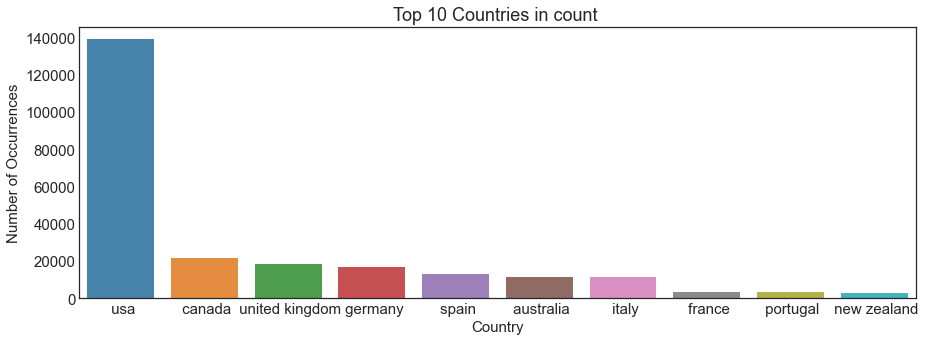

In [32]:
country_count  = users2["Country"].value_counts()
country_count = country_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Top 10 Countries in count ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Country', fontsize=15)
plt.show()

The chart below highlights the countries from whom the majority of the responses from readers were recorded for the data purposes where United States racks up the majority count, followed by Canada and the United States

## Exploring and Cleaning Books data set

In [33]:
# first drop the image columns (Image-URL-S,Image-URL-M, and Image-URL-L) from the data set
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [34]:
books.drop(['Image-URL-S','Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [35]:
print(books.dtypes)
books.columns = ['ISBN',"Book_title","Book_Author","Year_of_Publication","Publisher"]
print(books.info())
print(books.describe())

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book_title           271379 non-null  object
 2   Book_Author          271378 non-null  object
 3   Year_of_Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB
None
       Year_of_Publication
count        271379.000000
mean           1959.756050
std             258.011363
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000


In [36]:
# check for na and empty with the columns of the books dataset
books_na = books.isna().sum()
books_null = books.isnull().sum()

title_empty = books[books.Book_title == ""].Book_title .count()
Author_empty = books[books.Book_Author == ""].Book_Author.count()
year_empty = books[books.Year_of_Publication == 0].Year_of_Publication.count()
Publisher_empty = books[books.Publisher == ""].Publisher.count()

print(f'count of na in the books:\\ {books_na}')
print(f'count of null in the books:\\ {books_null}')
print(f'count of  cells in the title:\\ {100*title_empty/books.Book_title.count()} %')
print(f'count of empty cells in the Author:\\ {100*Author_empty/books.Book_Author.count()} %')
print(f'count of cells in the years with "0":\\ {100*year_empty/books.Year_of_Publication.count()} %')
print(f'count of empty cells in the Publisher:\\ {100*Publisher_empty/books.Publisher.count()} %')



count of na in the books:\ ISBN                   0
Book_title             0
Book_Author            1
Year_of_Publication    0
Publisher              2
dtype: int64
count of null in the books:\ ISBN                   0
Book_title             0
Book_Author            1
Year_of_Publication    0
Publisher              2
dtype: int64
count of  cells in the title:\ 0.0 %
count of empty cells in the Author:\ 0.0 %
count of cells in the years with "0":\ 1.7020476897622883 %
count of empty cells in the Publisher:\ 0.0 %


In [37]:
# Replace all years of zero with NaN
books.Year_of_Publication.replace(0, np.nan, inplace=True)

nan_value = float("NaN")
books.replace("", nan_value, inplace=True)
books.dropna(subset = ["Book_title"], inplace=True)
books.dropna(subset = ["Year_of_Publication"], inplace=True)
books.dropna(subset = ["Book_Author"], inplace=True)
books.dropna(subset = ["Publisher"], inplace=True)

In [38]:
# check for na and empty with the columns of the books dataset
books_na = books.isna().sum()
books_null = books.isnull().sum()

title_empty = books[books.Book_title == ""].Book_title .count()
Author_empty = books[books.Book_Author == ""].Book_Author.count()
year_empty = books[books.Year_of_Publication == 0].Year_of_Publication.count()
Publisher_empty = books[books.Publisher == ""].Publisher.count()

print(f'count of na in the books:\\ {books_na}')
print(f'count of null in the books:\\ {books_null}')
print(f'count of  cells in the title:\\ {100*title_empty/books.Book_title.count()} %')
print(f'count of empty cells in the Author:\\ {100*Author_empty/books.Book_Author.count()} %')
print(f'count of cells in the years with "0":\\ {100*year_empty/books.Year_of_Publication.count()} %')
print(f'count of empty cells in the Publisher:\\ {100*Publisher_empty/books.Publisher.count()} %')


count of na in the books:\ ISBN                   0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64
count of null in the books:\ ISBN                   0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64
count of  cells in the title:\ 0.0 %
count of empty cells in the Author:\ 0.0 %
count of cells in the years with "0":\ 0.0 %
count of empty cells in the Publisher:\ 0.0 %


In [39]:
#Checking the descriptive stats of the range of years the books were published in the dataset
print(books.describe())



       Year_of_Publication
count        266757.000000
mean           1993.689534
std               8.326039
min            1376.000000
25%            1989.000000
50%            1996.000000
75%            2000.000000
max            2050.000000


### It seems there are books that has dates of 1376 and books that has future dates. all of this will be cosidered as wrong inputs, so lets check the count of these books

In [40]:
#print(old_books = books[books.Year_of_Publication<1900])
print(f'outlaiers with old dates: {books[books.Year_of_Publication <1900].Year_of_Publication.count()}')
print(f'outlaiers with future dates: {books[books.Year_of_Publication >2019].Year_of_Publication.count()}')


print(f'Based on the count of the outlaiers we will remove the the rows for these books')

outlaiers with old dates: 4
outlaiers with future dates: 17
Based on the count of the outlaiers we will remove the the rows for these books


In [41]:
books = books[books['Year_of_Publication'] >= 1900 ]  
books = books[books['Year_of_Publication'] <= 2019 ]  
print(books.describe())
print(books.count())

       Year_of_Publication
count        266736.000000
mean           1993.692887
std               8.137504
min            1900.000000
25%            1989.000000
50%            1996.000000
75%            2000.000000
max            2012.000000
ISBN                   266736
Book_title             266736
Book_Author            266736
Year_of_Publication    266736
Publisher              266736
dtype: int64


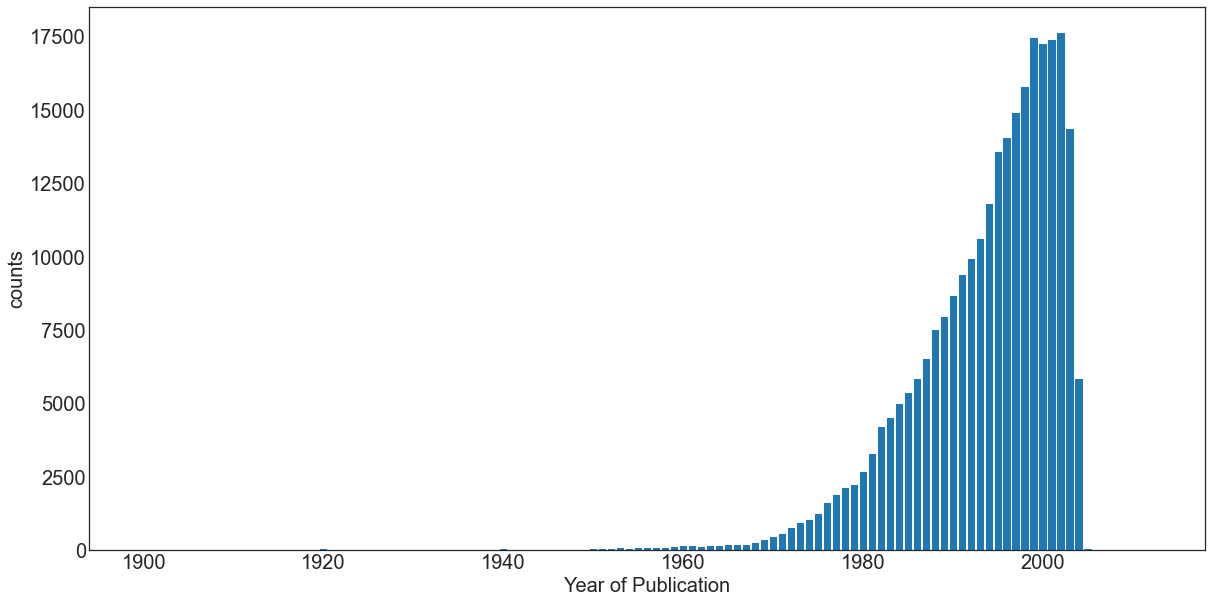

In [42]:
# plot to show the years destribution

yr = books.Year_of_Publication.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20}) 
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

The graph below highlights the amount of books that were published through out the years with the adjusted dataset
The distribution has a negative skewness, meaning as years progressed more books were published by each year (till mid-2000s)

In [43]:
books.head(20)


,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993.0,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996.0,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner


It seems there is a problem with the "&" in the publisher name

In [44]:
books.Publisher = books.Publisher.str.replace('&amp', '&', regex=False)

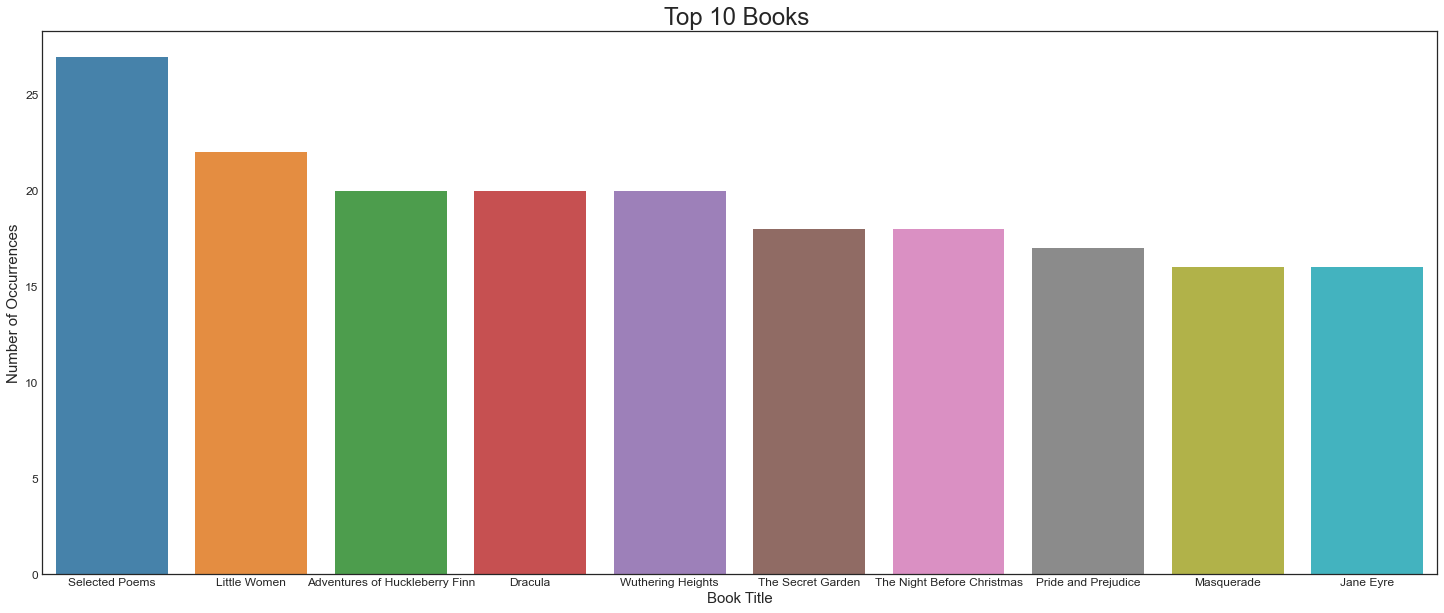

In [45]:
Top_books  = books["Book_title"].value_counts()
Top_books = Top_books[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_books.index, Top_books.values, alpha=0.9)
plt.title('Top 10 Books ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

The chart above highlights the top 10 books preferred by readers throughout the years with "Selected Poems" taking the top spot, followed by "Little Women" and "Adventures of Huckleberry Finn"

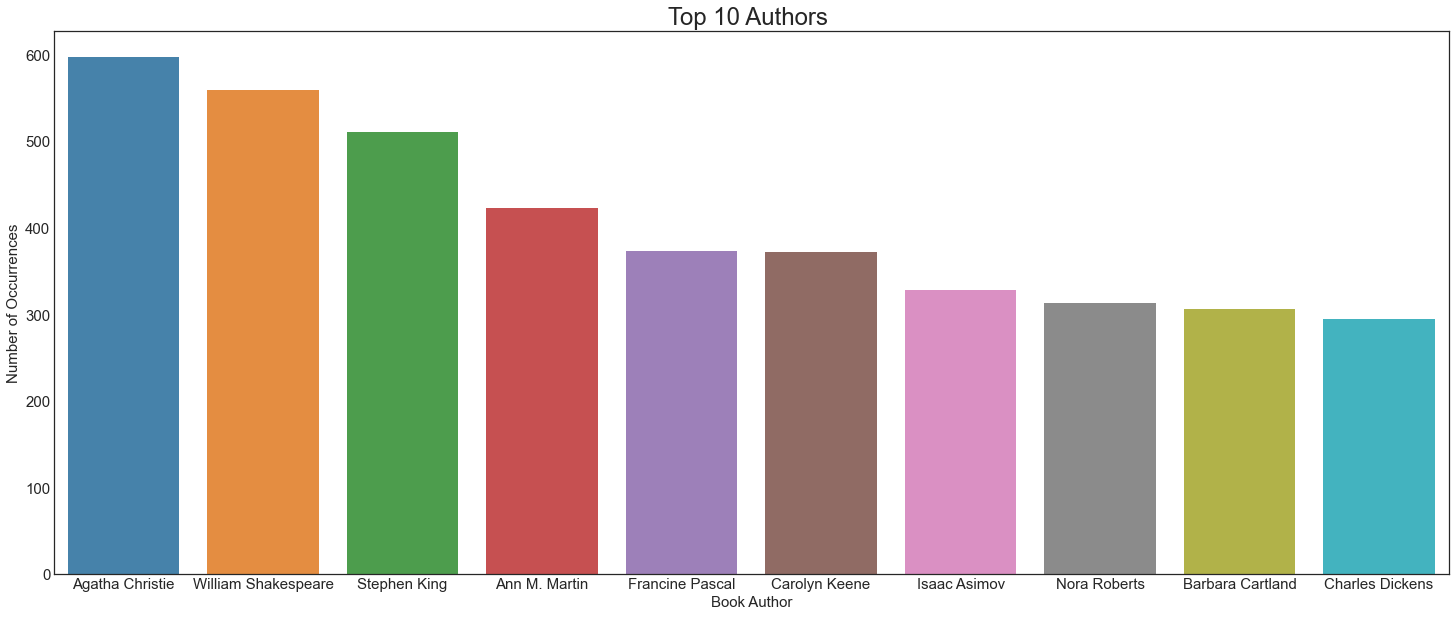

In [46]:
Top_Author  = books["Book_Author"].value_counts()
Top_Author = Top_Author[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_Author.index, Top_Author.values, alpha=0.9)
plt.title('Top 10 Authors ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Author', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

The chart above highlights the top 10 authors readers have taken preference of throughout the years with Agatha Christie establishing herself as a top author on the chart, followed by William Shakespeare and Stephen King

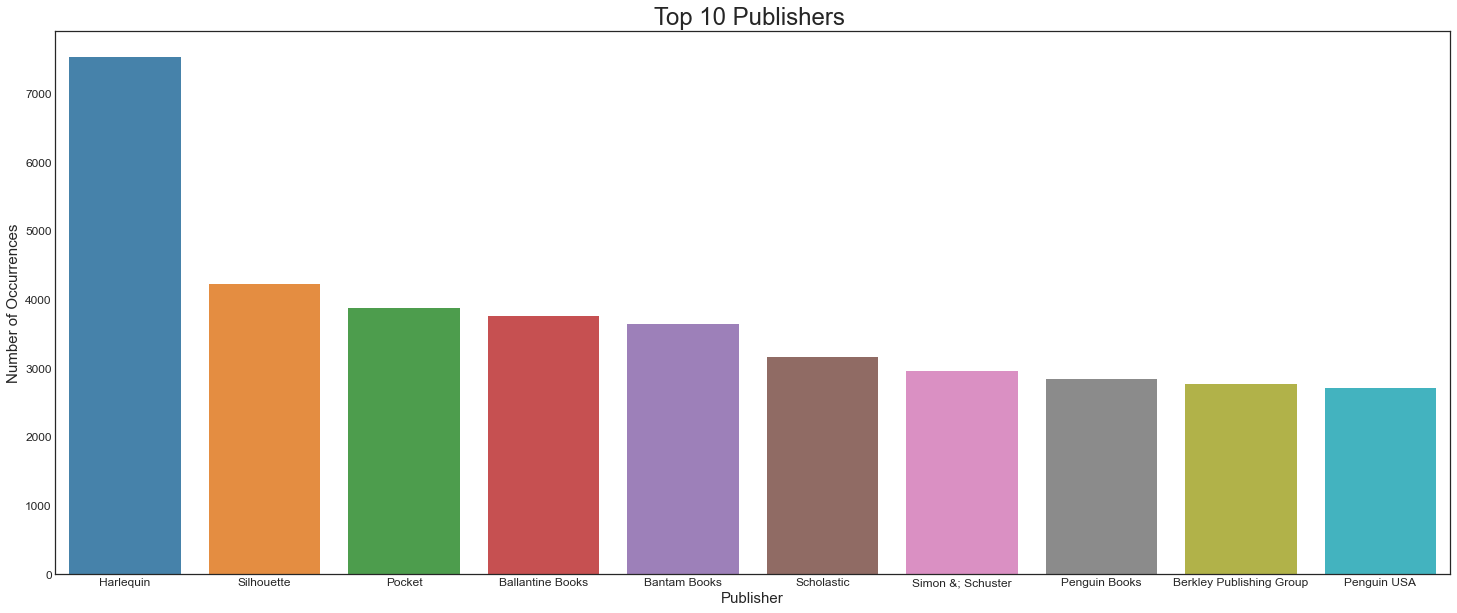

In [47]:
Top_Publisher  = books["Publisher"].value_counts()
Top_Publisher = Top_Publisher[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_Publisher.index, Top_Publisher.values, alpha=0.9)
plt.title('Top 10 Publishers ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Publisher', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

The chart below highlights the top 10 publishers/publishing companies for all the books throughout the years with Harlequin taking the majority of the top spot, followed by Silhouette and Packet

In [48]:
# checking for duplicate books 
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep=False))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep='first'))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author']))].Book_Author.value_counts().head())

              ISBN                      Book_title      Book_Author  \
count        34936                           34936            34936   
unique       34936                           15057             7577   
top     186207481X  Adventures of Huckleberry Finn  Agatha Christie   
freq             1                              20              249   

               Publisher  
count              34936  
unique              2370  
top     Ballantine Books  
freq                1082  
              ISBN                      Book_title   Book_Author  \
count        19524                           19524         19524   
unique       19524                           15057          7577   
top     186207481X  Adventures of Huckleberry Finn  Stephen King   
freq             1                              19           183   

               Publisher  
count              19524  
unique              1912  
top     Ballantine Books  
freq                 583  
Stephen King           183
Agatha

In [49]:
# it seems that the boos are duplicated due to differnet publishers over the world. so we will use only one version of the books to avoid duplicates in the recomender model her is an example for the book of "Life of Pi'"
books[books.Book_title=='Life of Pi']

,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
246,0151008116,Life of Pi,Yann Martel,2002.0,Harcourt
563,0156027321,Life of Pi,Yann Martel,2003.0,Harvest Books
8745,1565117794,Life of Pi,Yann Martel,2003.0,Highbridge Audio
62892,184195425X,Life of Pi,Yann Martel,2004.0,Pub Group West


It appears that the books are duplicated due to different publishers around the world. Hence we will use only one version of the books to avoid duplicates in the recomender model her is an example for the book of "Life of Pi'"

In [50]:
#Eliminating the duplications of books
books = books.drop_duplicates(['Book_title', 'Book_Author'])
books.describe(include=[object,int])

,ISBN,Book_title,Book_Author,Publisher
count,247212,247212,247212,247212
unique,247212,238512,100667,16224
top,0590624245,Selected Poems,William Shakespeare,Harlequin
freq,1,25,490,7508


In [51]:
#Checking for the duplications
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep=False))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep='first'))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author']))].Book_Author.value_counts().head())

books[books.Book_title=='Life of Pi']

       ISBN Book_title Book_Author Publisher
count     0          0           0         0
unique    0          0           0         0
top     NaN        NaN         NaN       NaN
freq    NaN        NaN         NaN       NaN
       ISBN Book_title Book_Author Publisher
count     0          0           0         0
unique    0          0           0         0
top     NaN        NaN         NaN       NaN
freq    NaN        NaN         NaN       NaN
Series([], Name: Book_Author, dtype: int64)


,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
246,0151008116,Life of Pi,Yann Martel,2002.0,Harcourt


Output appears to show the duplicates no longer exist and there is only one true cell of book with its title, author, and publisher

## Exploring and Cleaning Books ratings set

In [52]:
ratings.columns = ['User_id',"ISBN","Rating"]
ratings.head()

,User_id,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


print(ratings.dtypes)
ratings.describe()

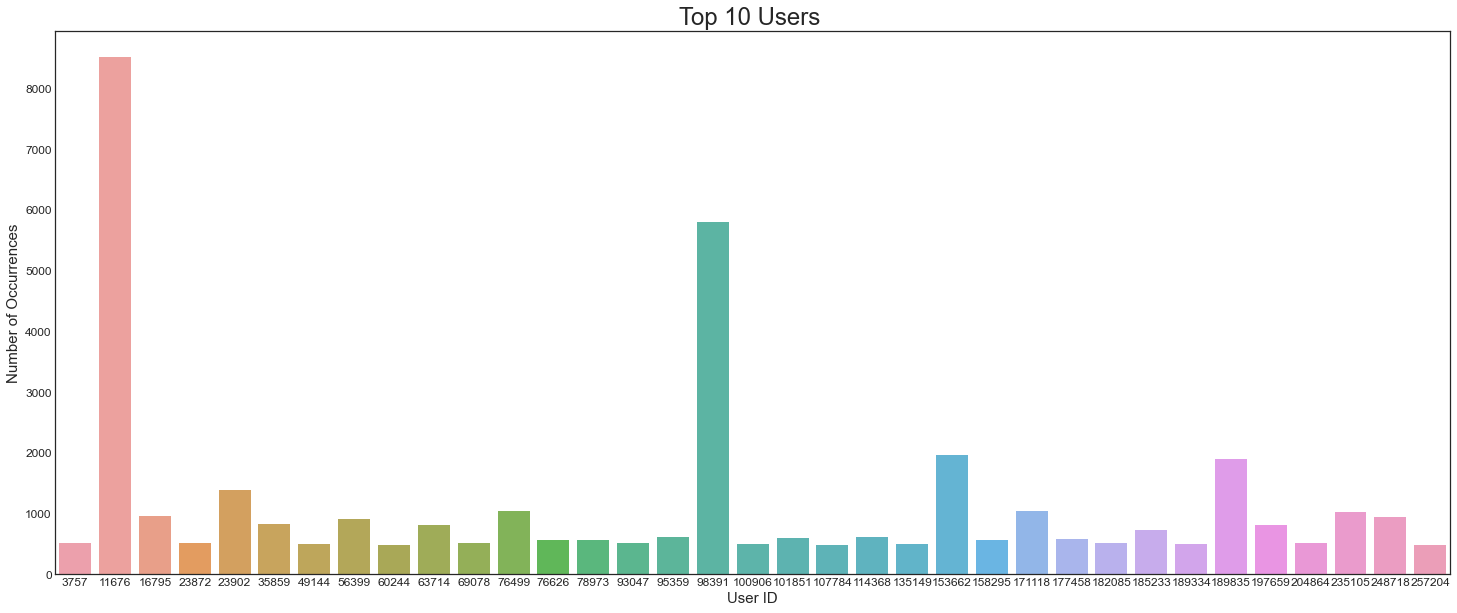

In [143]:
Top_user  = ratings["User_id"].value_counts()
Top_user = Top_user[:35,]
plt.figure(figsize=(25,10))
sns.barplot(Top_user.index, Top_user.values, alpha=0.9)
plt.title('Top 10 Users ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

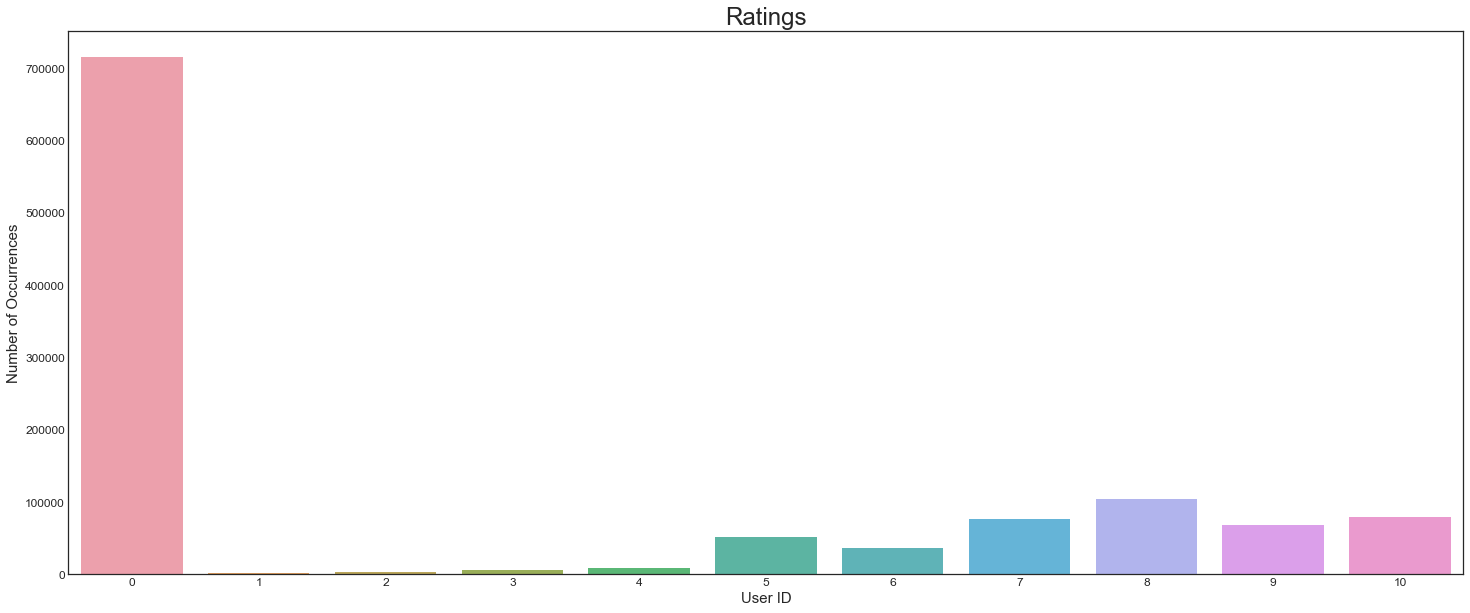

In [54]:
#Ratings destribution
Rate_distrbt  = ratings["Rating"].value_counts()
plt.figure(figsize=(25,10))
sns.barplot(Rate_distrbt.index, Rate_distrbt.values, alpha=0.9)
plt.title('Ratings')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

Based on the describtion, these rating are implicit and explicit.  The explicit ratings represented by 1–10 and implicit ratings represented by 0 will have to be segregated now. We will be using only explicit ratings for building our book recommendation system. Similarly, users are also segregated into those who rated explicitly and those whose implicit behavior was recorded.

In [55]:
ratings = ratings[ratings.Rating != 0]

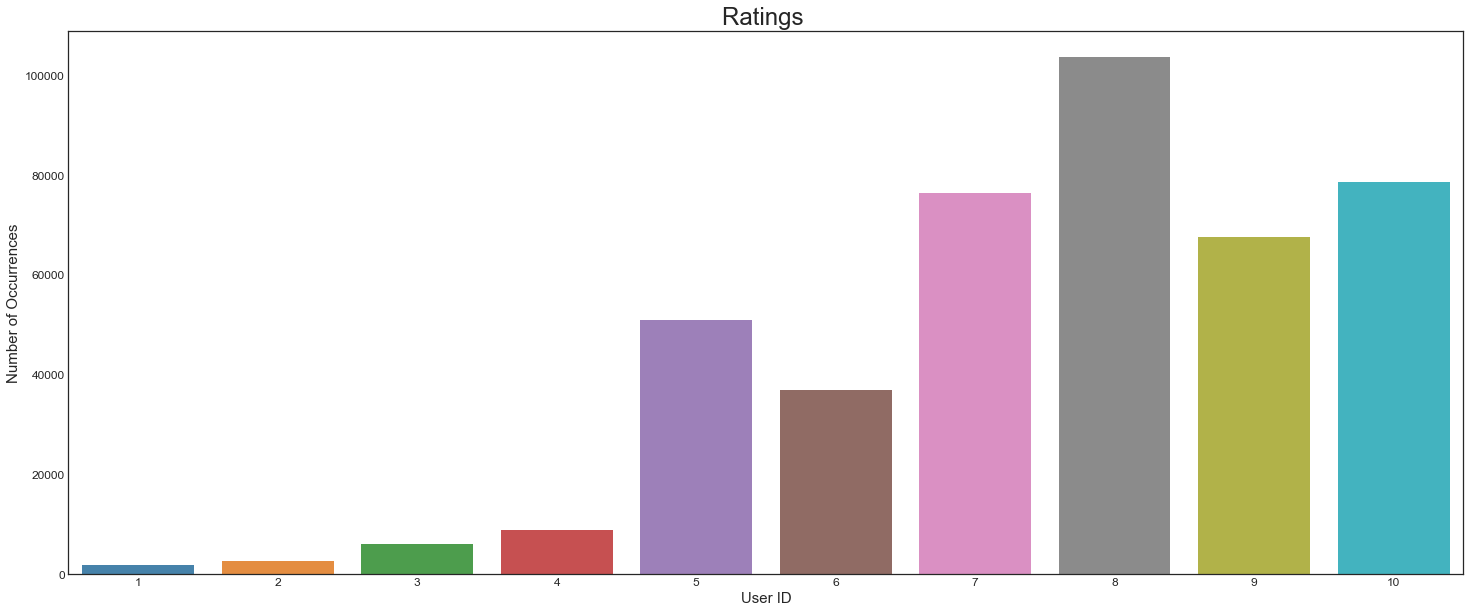

In [56]:
#Ratings destribution
Rate_distrbt = ratings["Rating"].value_counts()
plt.figure(figsize=(25,10))
sns.barplot(Rate_distrbt.index, Rate_distrbt.values, alpha=0.9)
plt.title('Ratings ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

## Joining the datasets

Before Joining the datasets we will work with the data filtered for users with more than 4 ratings and the top 20% most frequnt rated books due to the computing poer

In [57]:
user_ratings_threshold = 4

filter_users = ratings['User_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

ratings2 = ratings[ratings['User_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(ratings)))

Filter: users with at least 4 ratings
Number of records: 433671


In [58]:
book_ratings_threshold_perc = 0.20
book_ratings_threshold = len(ratings2['ISBN'].unique()) * book_ratings_threshold_perc

filter_books_list = ratings2['ISBN'].value_counts().head(int(book_ratings_threshold)).index.to_list()
ratings2 = ratings2[ratings2['ISBN'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(ratings2)))

Filter: top 20% most frequently rated books
Number of records: 208310


In [59]:
books_ratings = ratings2.join(books.set_index('ISBN'), on='ISBN')

In [60]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208310 entries, 16 to 1149775
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              208310 non-null  int64  
 1   ISBN                 208310 non-null  object 
 2   Rating               208310 non-null  int64  
 3   Book_title           170784 non-null  object 
 4   Book_Author          170784 non-null  object 
 5   Year_of_Publication  170784 non-null  float64
 6   Publisher            170784 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 12.7+ MB


In [61]:
books_ratings.head()

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch
19,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995.0,Pocket
20,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997.0,Vintage Books USA
33,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon
77,276786,8437606322,8,NaN,NaN,NaN,NaN


In [62]:
books_ratings.isnull().sum()

User_id                    0
ISBN                       0
Rating                     0
Book_title             37526
Book_Author            37526
Year_of_Publication    37526
Publisher              37526
dtype: int64

As per the above it seems that some ISBN that are rated has no books linked to them. this will be cleaned later

In [63]:
books_ratings.dropna(subset=['Book_title'], inplace=True) 

In [64]:
books_ratings.isnull().sum()

User_id                0
ISBN                   0
Rating                 0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64

In [65]:
#Join users data sets with books_ratings
ratings_wth_detls = books_ratings.join(users2.set_index('User_id'), on='User_id')

In [66]:
ratings_wth_detls.head()

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,25.0,iowa city,iowa,usa
19,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995.0,Pocket,25.0,iowa city,iowa,usa
20,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997.0,Vintage Books USA,25.0,iowa city,iowa,usa
33,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon,25.0,duisburg,nordrhein-westfalen,germany
81,276786,8478442588,6,El Elogio de La Sombra,Tanazaki,1998.0,Siruela,34.0,madrid,madrid,spain


In [67]:
ratings_wth_detls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170784 entries, 16 to 1149775
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              170784 non-null  int64  
 1   ISBN                 170784 non-null  object 
 2   Rating               170784 non-null  int64  
 3   Book_title           170784 non-null  object 
 4   Book_Author          170784 non-null  object 
 5   Year_of_Publication  170784 non-null  float64
 6   Publisher            170784 non-null  object 
 7   Age                  170740 non-null  float64
 8   City                 170740 non-null  object 
 9   State                170551 non-null  object 
 10  Country              165690 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 15.6+ MB


In [68]:
ratings_wth_detls.isnull().sum()

User_id                   0
ISBN                      0
Rating                    0
Book_title                0
Book_Author               0
Year_of_Publication       0
Publisher                 0
Age                      44
City                     44
State                   233
Country                5094
dtype: int64

In [69]:
# we will drop all the missing values from "age","city","State" and "Country"

ratings_wth_detls.dropna(subset=['Age','City','State','Country'], inplace=True) 

In [70]:
ratings_wth_detls.isnull().sum()

User_id                0
ISBN                   0
Rating                 0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
Age                    0
City                   0
State                  0
Country                0
dtype: int64

In [71]:
ratings_wth_detls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165501 entries, 16 to 1149775
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              165501 non-null  int64  
 1   ISBN                 165501 non-null  object 
 2   Rating               165501 non-null  int64  
 3   Book_title           165501 non-null  object 
 4   Book_Author          165501 non-null  object 
 5   Year_of_Publication  165501 non-null  float64
 6   Publisher            165501 non-null  object 
 7   Age                  165501 non-null  float64
 8   City                 165501 non-null  object 
 9   State                165501 non-null  object 
 10  Country              165501 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 15.2+ MB


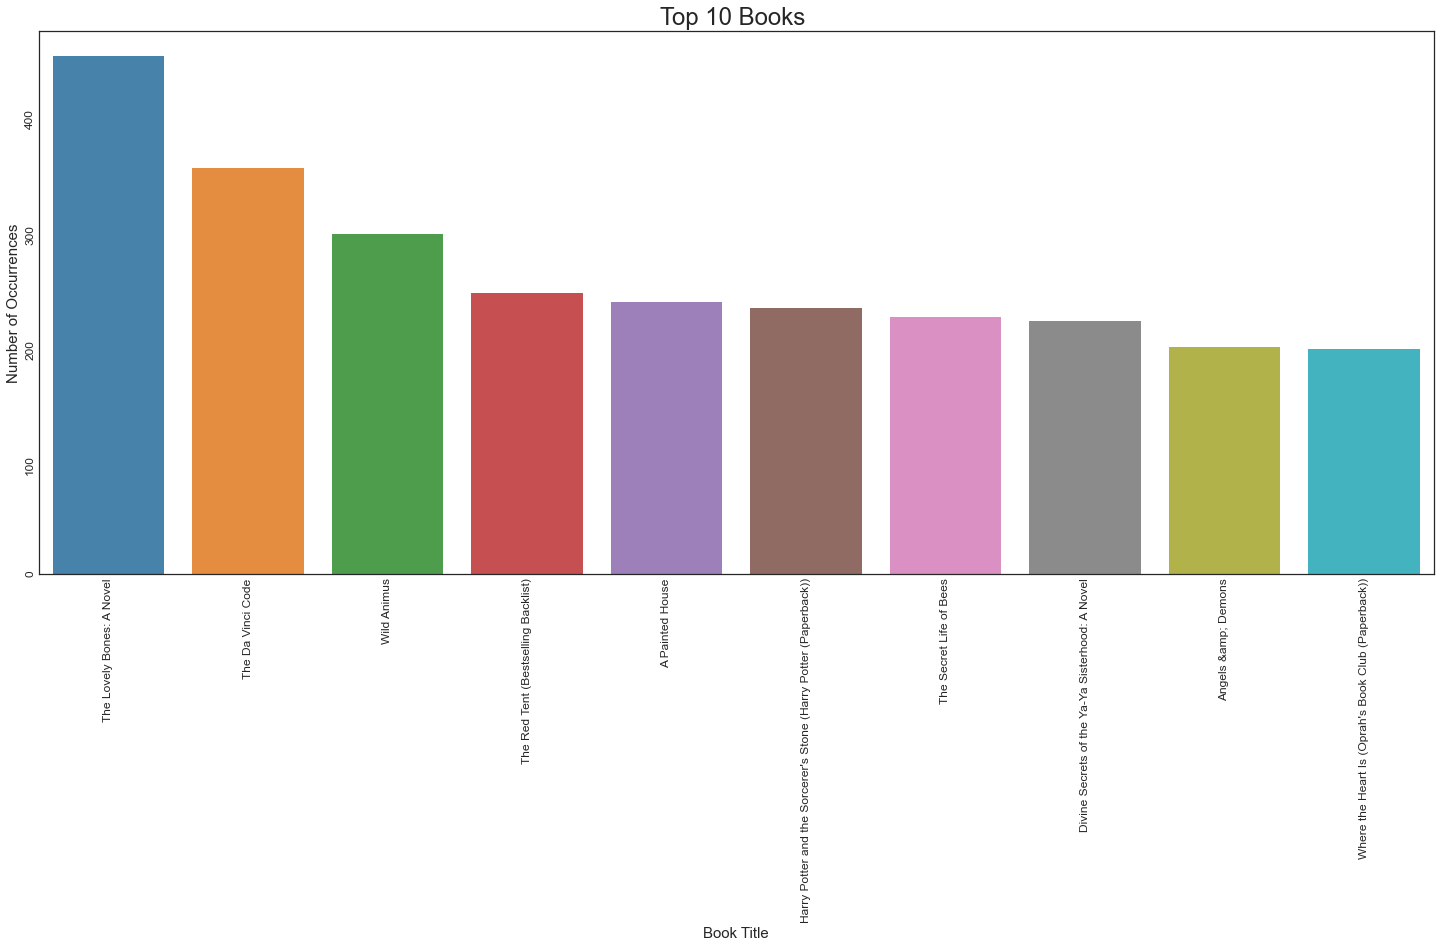

In [72]:
Top_books  = ratings_wth_detls["Book_title"].value_counts()
Top_books = Top_books[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_books.index, Top_books.values, alpha=0.9)
plt.title('Top 10 Books ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12, rotation=90)
plt.show()

After further cleaning, the chart above lists the top 10 books enlisted by readers based on title throughout the years of the dataset. This highlights "The lovely Bones: A Novel" as the top read novel by readers; followed by "Wild Animus" and "The Da Vinci Code"

In [73]:
BK_RT = ratings_wth_detls[['Book_title', 'Rating']]

BK_RT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165501 entries, 16 to 1149775
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Book_title  165501 non-null  object
 1   Rating      165501 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


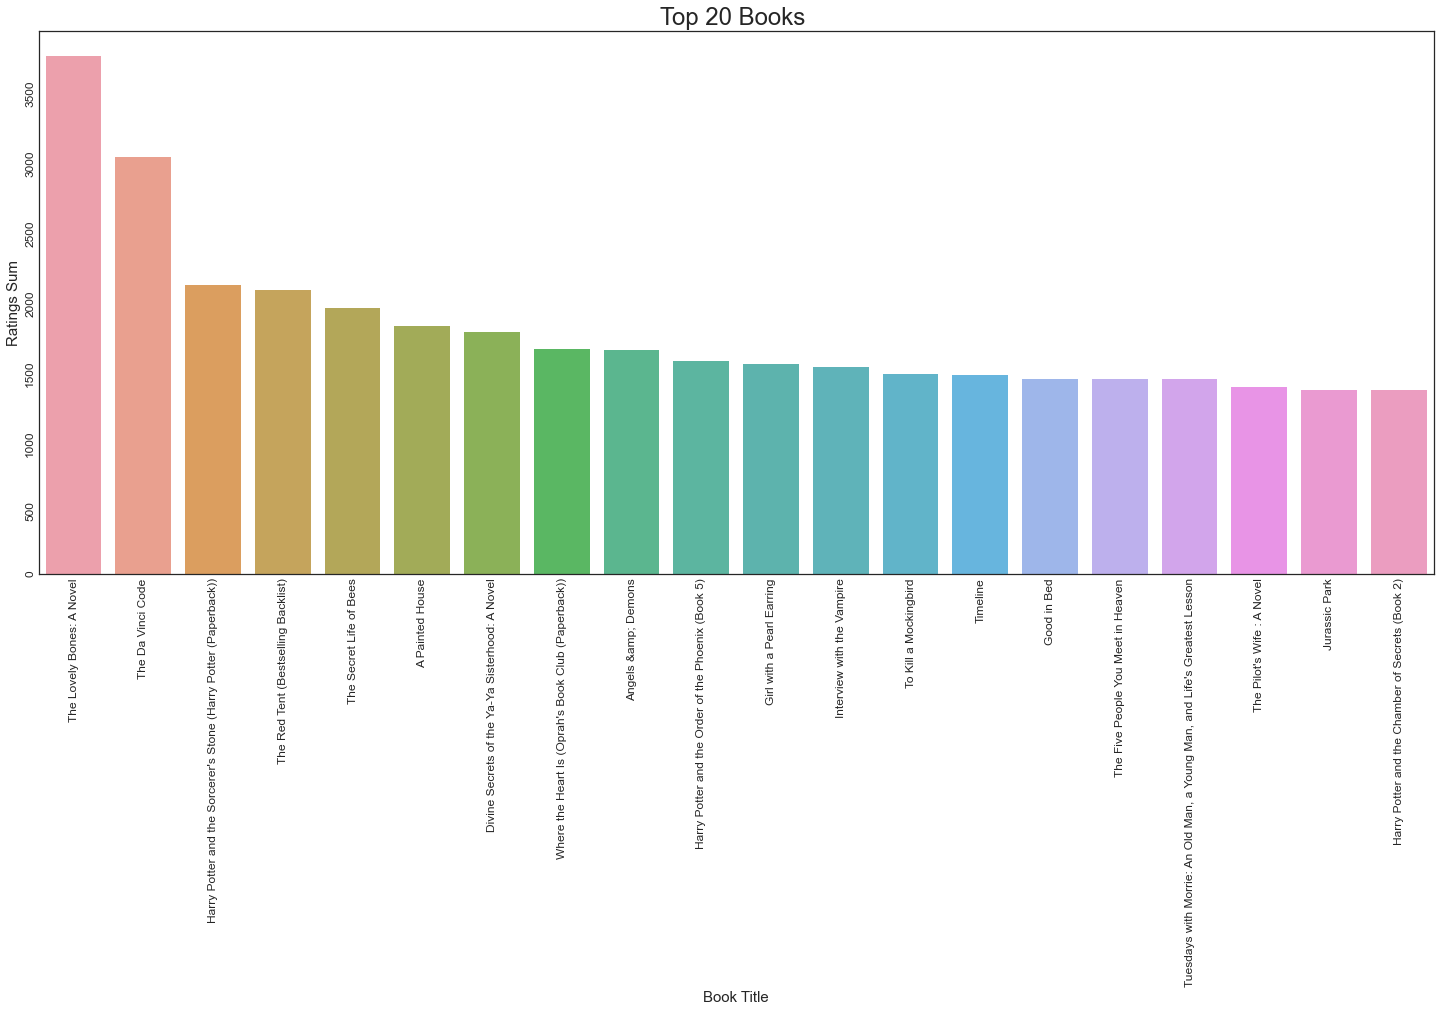

In [74]:
#Top 20 Books is the Rating totals
BR_sum = BK_RT.groupby('Book_title').Rating.sum()
BR_sum = BR_sum.sort_values(ascending=False)[:20]
plt.figure(figsize=(25,10))
sns.barplot(BR_sum.index, BR_sum.values, alpha=0.9)
plt.title('Top 20 Books ')
plt.ylabel('Ratings Sum', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12, rotation=90 )
plt.show()

The chart below highlights the Top 20 Books assessed and rated on readers' preference with "The lovely Bones: A Novel" having the highest rating amongst others; followed by "The Da Vinci Code" and "The Red Tent"

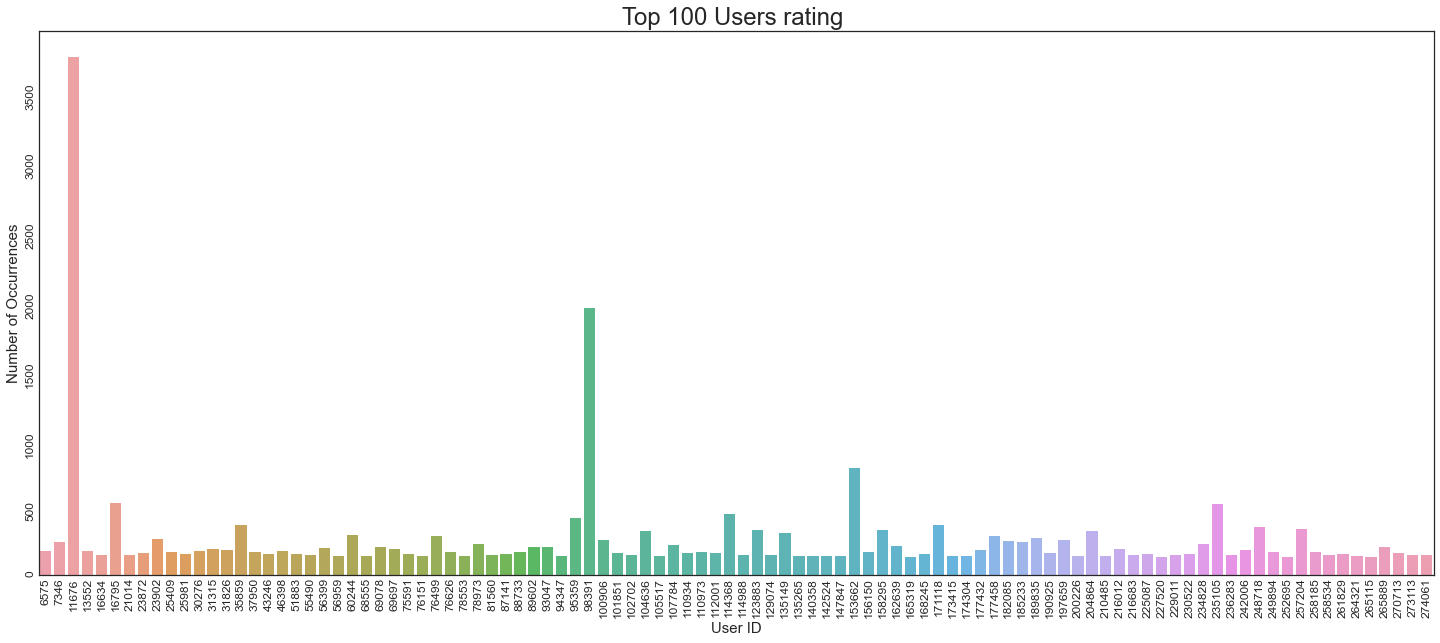

In [75]:
Top_user_id  = ratings_wth_detls["User_id"].value_counts()
Top_user_id = Top_user_id[:100,].sort_values()
plt.figure(figsize=(25,10))
sns.barplot(Top_user_id.index, Top_user_id.values, alpha=0.9)
plt.title('Top 100 Users rating ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12, rotation=90)
plt.show()

# Recommendation systems


### Collaborative Filtering Based Recommendation Systems ###

- We will compar sevral models and look at the RMSE  to find the modle with lowest RMSE and try to tune the modle for better performance
- We useing SurPRISE libraray  Simple Python RecommendatIon System Engine as it providea various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
- We will use only the User_ID, ISBN and Ratings as inputs for the algorithms to built the matrix and compare the RMSE
- The for Algorithms used in the notebook are ( KNN_with_menas, KNN_Basic, SVD, NMF)


In [76]:
ratings_wth_detls.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165501 entries, 16 to 1149775
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              165501 non-null  int64  
 1   ISBN                 165501 non-null  object 
 2   Rating               165501 non-null  int64  
 3   Book_title           165501 non-null  object 
 4   Book_Author          165501 non-null  object 
 5   Year_of_Publication  165501 non-null  float64
 6   Publisher            165501 non-null  object 
 7   Age                  165501 non-null  float64
 8   City                 165501 non-null  object 
 9   State                165501 non-null  object 
 10  Country              165501 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 15.2+ MB


In [77]:

df = pd.DataFrame(ratings_wth_detls)
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_wth_detls[['User_id', 'ISBN', 'Rating']], reader)


In [78]:
df1 = pd.DataFrame(df[['User_id', 'ISBN', 'Rating']])

df2 = pd.DataFrame(df1[df1.groupby('User_id')['User_id'].transform('size') > 3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153288 entries, 133 to 1149746
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User_id  153288 non-null  int64 
 1   ISBN     153288 non-null  object
 2   Rating   153288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.7+ MB


In [79]:
data2 = Dataset.load_from_df(df2[['User_id', 'ISBN', 'Rating']], reader)

### KNN With Means model

In [80]:

KNNWithMeansmodel = KNNWithMeans()

cv_results_knn= cross_validate(KNNWithMeansmodel, data,  measures=['RMSE'], cv=5, verbose=True)
pd.DataFrame(cv_results_knn).mean()


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8055  1.8127  1.7981  1.7994  1.7949  1.8021  0.0063  
Fit time          30.74   19.07   25.49   21.68   20.42   23.48   4.22    
Test time         4.84    2.51    3.24    3.42    2.36    3.27    0.88    


test_rmse     1.802133
fit_time     23.480053
test_time     3.274603
dtype: float64

### KNN_Basic

In [81]:
KNNBasicmodel = KNNBasic()
cv_results_knnBas= cross_validate(KNNBasicmodel, data,  measures=['RMSE'], cv=5, verbose=True)
pd.DataFrame(cv_results_knnBas).mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9797  1.9782  1.9707  1.9508  1.9597  1.9678  0.0111  
Fit time          16.73   17.81   16.84   19.75   18.01   17.83   1.09    
Test time         3.03    3.50    3.56    2.15    2.83    3.01    0.51    


test_rmse     1.967828
fit_time     17.829104
test_time     3.011375
dtype: float64

### SVD 

In [82]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=5)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.599991
test_mae      1.235236
fit_time     13.984167
test_time     0.465123
dtype: float64

### NMF

In [83]:

model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=5)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.672199
test_mae      2.280880
fit_time     19.688934
test_time     0.478433
dtype: float64

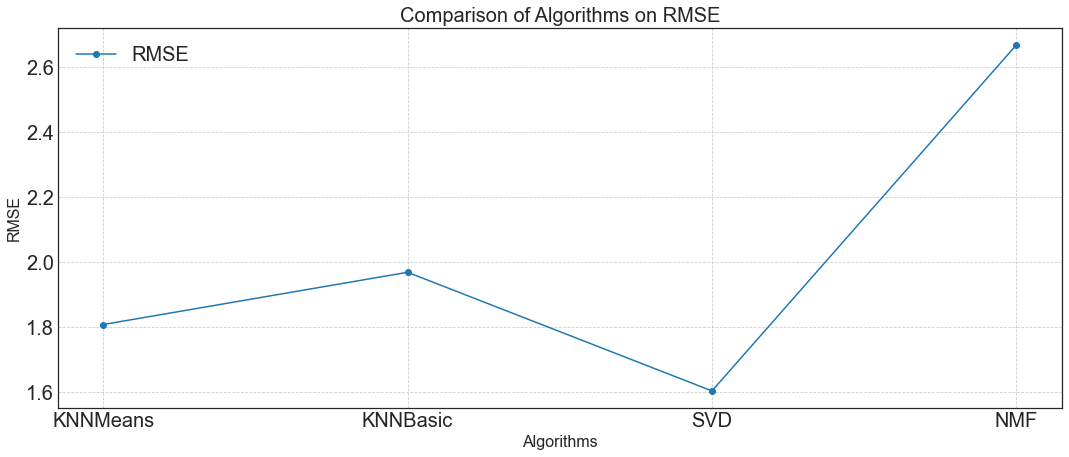

In [84]:
Algorithms = ['KNNMeans','KNNBasic','SVD', 'NMF']
#mannullt recode mean RMSE...since re-running takes too much time
rmse_results =[1.806518, 1.967200, 1.602316, 2.666205]

#rmse vs. algorithms
plt.figure(figsize=(18,7))
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=20)
plt.plot(Algorithms, rmse_results, label='RMSE', marker='o')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.grid(ls='dashed')
plt.legend()
plt.show()

The graph above highlights the four types of Algorithms that were assessed based on RMSE. It appears that SVD has the lowest error of the four and hence will be utilized for the validation of the test dataset

## Tunning the SVD to find the best configuration of parameters.

n_factors - the number of factors.
n_epochs - the number of iteration of the SGD procedure.


lr_all - the learning rate for all parameters.

reg_all - the regularization term for all parameters.

As a result, there was a minor improvement obtained with the tunning.


### Testing and analysing the SVD Collaborative Filtering model through the train test and 10% test data

In [99]:
import random
my_seed = 50
random.seed(my_seed)
np.random.seed(my_seed)
trainset, testset = train_test_split(data, test_size=0.10)

model = SVD(n_factors=50, n_epochs=20, lr_all=0.008, reg_all=0.2)
model.fit(trainset)
model.qi.shape
predictions = model.test(testset)


In [100]:
# checking the matrix shape
print(model.qi.shape)


pd.DataFrame(model.qi).iloc[0].pow(2).sum()
model.qi /= np.linalg.norm(model.qi, ord=2, axis=1).reshape(-1, 1)
pd.DataFrame(model.qi).iloc[0].pow(2).sum()

(26266, 50)


1.0000000000000002

#### Testing the mdoel with inputing some User_id and book ISBN to check the Rating predection


In [101]:
model.predict('276762','3453092007')

Prediction(uid='276762', iid='3453092007', r_ui=None, est=7.725619335347432, details={'was_impossible': False})

In [102]:
model.predict('208492','0312990456')

Prediction(uid='208492', iid='0312990456', r_ui=None, est=8.234155086506101, details={'was_impossible': False})

In [103]:
# Looking at the RMSE of the model

cv_results_svd1 = cross_validate(model, data, cv=5)
print(cv_results_svd1)
pd.DataFrame(cv_results_svd1).mean()

{'test_rmse': array([1.58224908, 1.58858396, 1.57876063, 1.58560117, 1.59794619]), 'test_mae': array([1.22527735, 1.23611367, 1.22349233, 1.23084819, 1.2382368 ]), 'fit_time': (8.33570146560669, 5.6833367347717285, 5.803693771362305, 6.564506530761719, 5.537665128707886), 'test_time': (0.5643768310546875, 0.3232421875, 0.22684025764465332, 0.23275017738342285, 0.28055548667907715)}


test_rmse    1.586628
test_mae     1.230794
fit_time     6.384981
test_time    0.325553
dtype: float64

#### Below joined the matrix with the orginal data set to calaculate the absolut error betwen predection and orginal rating

In [104]:
df_pred = pd.DataFrame(predictions, columns=['User_id', 'ISBN', 'actual_rating', 'pred_rating', 'details'])
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(20)

,User_id,ISBN,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
14825,239626,0064410382,10.0,9.481949,False,9.0,0.518051
10674,274549,0440211727,8.0,7.420321,False,7.0,0.579679
10300,226987,0805425500,5.0,7.593275,False,8.0,2.593275
2393,229741,0060234938,8.0,7.241265,False,7.0,0.758735
3682,187805,2253044911,8.0,8.521157,False,9.0,0.521157
2867,6280,8420633135,5.0,7.473273,False,7.0,2.473273
4421,8253,038572179X,10.0,8.673286,False,9.0,1.326714
8672,216683,0553211404,8.0,8.144350,False,8.0,0.144350
6814,191020,0451401670,7.0,7.576410,False,8.0,0.576410
11293,80071,0679723161,6.0,8.159140,False,8.0,2.159140


### Comparison between the destribution of the actual ratings vs the predicted ratings 

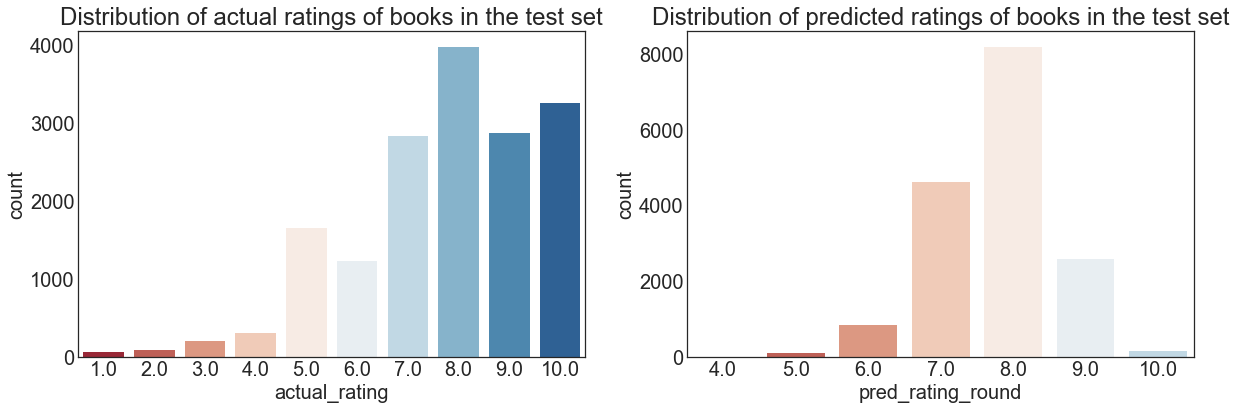

In [106]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

When comparing the actual and predicted values destribution of ratingsacross the datasets, the predicted ratings , it appears that the rating 8 has the higest counts over the 2 datasets but while the rest of the destribution between 5 and 10 is not identical show more users to rate 7, 9 and 10 wihile it is prdeicted at 8 by the model.
This is offcoursethe reflection of the RMSE error of 1.5.
These means the modle is not as perfect but it might give a an idea for the user about the books. probabbly if we could integrate the books genre to the details and the age of the users that would improve the model RMSE and give better insights to the analysis.

This is also shown in the graphs below fro the error destribution

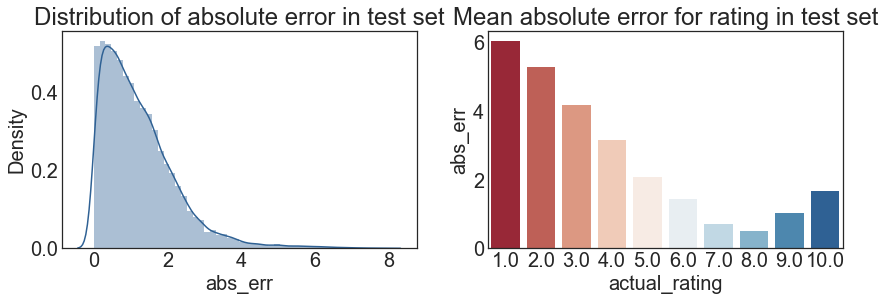

In [107]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [108]:
df_ext = df.merge(df_pred[['ISBN', 'User_id','pred_rating', 'abs_err']], on=['ISBN', 'User_id'], how='left')
df_ext.head(30)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating,abs_err
0,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,25.0,iowa city,iowa,usa,NaN,NaN
1,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995.0,Pocket,25.0,iowa city,iowa,usa,NaN,NaN
2,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997.0,Vintage Books USA,25.0,iowa city,iowa,usa,NaN,NaN
3,276762,0380711524,5,See Jane Run,Joy Fielding,1992.0,Avon,25.0,duisburg,nordrhein-westfalen,germany,NaN,NaN
4,276786,8478442588,6,El Elogio de La Sombra,Tanazaki,1998.0,Siruela,34.0,madrid,madrid,spain,NaN,NaN
5,276813,8426449476,8,El Diaro De Bridget Jones,Helen Fielding,1996.0,Lumen Espana,29.0,sitges,barcelona,spain,NaN,NaN
6,276813,8426449573,6,Bridget Jones:SobrevivirÃ©,Helen Fielding,2000.0,Downtown Book Center Inc,29.0,sitges,barcelona,spain,NaN,NaN
7,276822,0060096195,10,The Boy Next Door,Meggin Cabot,2002.0,Avon Trade,11.0,calgary,alberta,canada,NaN,NaN
8,276822,0141310340,9,Skin and Other Stories (Now in Speak!),Roald Dahl,2002.0,Puffin Books,11.0,calgary,alberta,canada,8.003404,0.996596
9,276822,0142302198,10,Growing Wings,Laurel Winter,2002.0,Puffin Books,11.0,calgary,alberta,canada,8.485911,1.514089


### Some Ploting of errors against users and books for explortation  

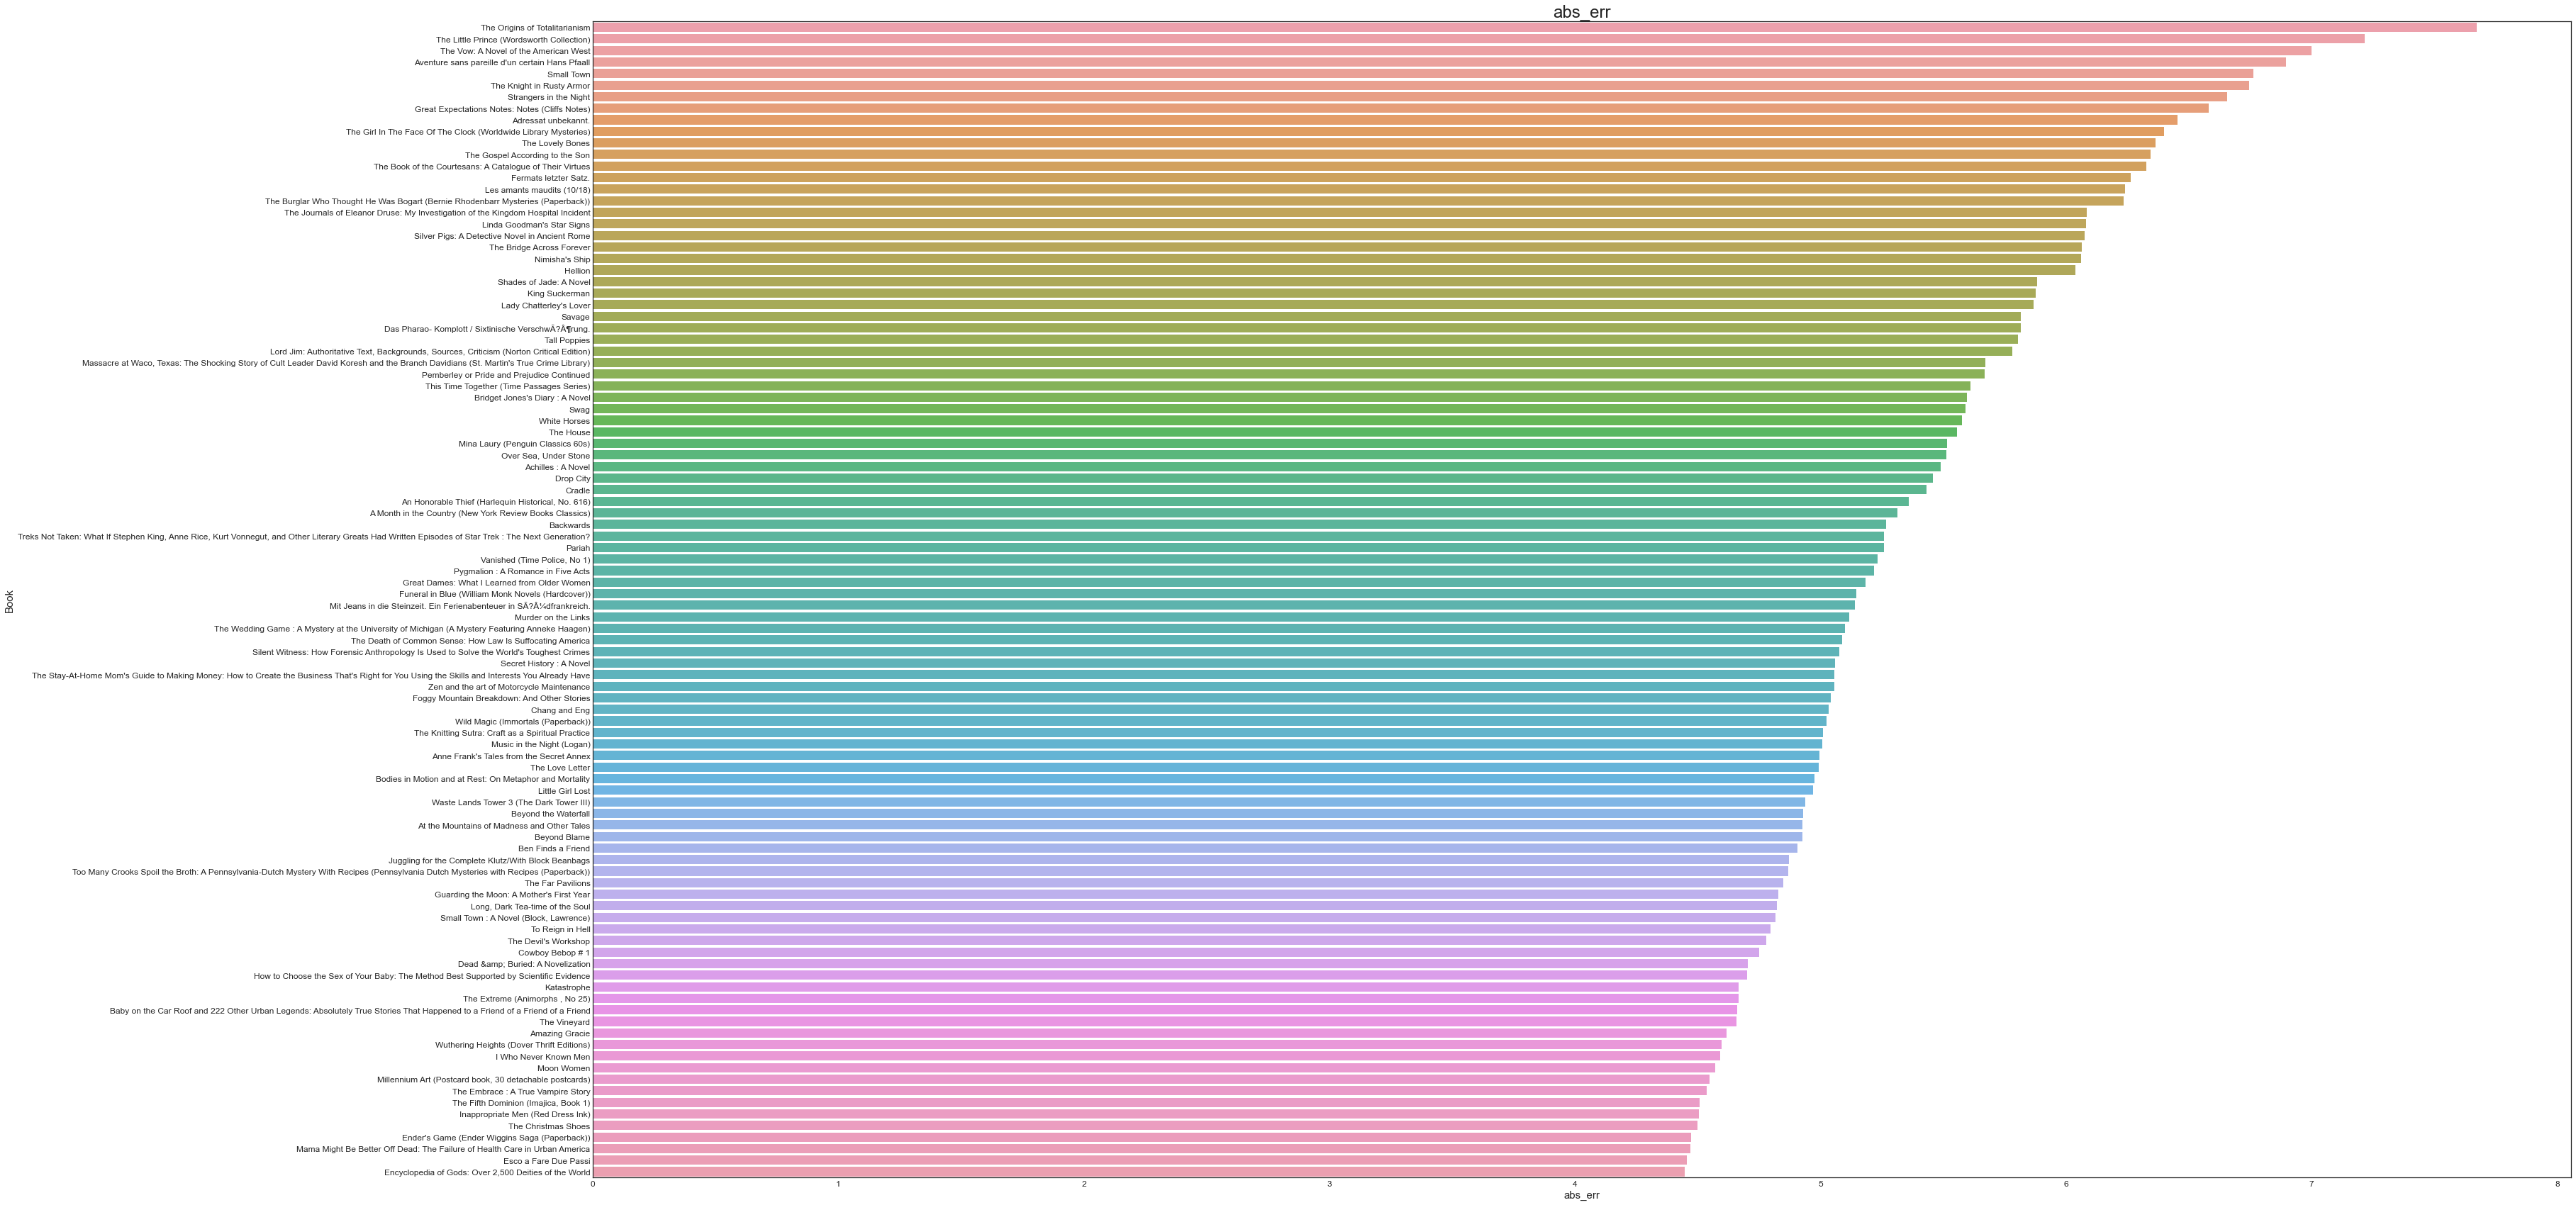

In [109]:
# 100 Books with the highest mean error in prediction 
df_Cou_err = df_ext.groupby('Book_title')['abs_err'].mean().reset_index()
df_Cou_err  = df_Cou_err.sort_values('abs_err', ascending=False)[:100]
plt.figure(figsize=(50,30))
sns.barplot(df_Cou_err['abs_err'], df_Cou_err['Book_title'], alpha=0.9)
plt.title('abs_err')
plt.ylabel('Book', fontsize=15)
plt.xlabel('abs_err', fontsize=15)
plt.tick_params(labelsize=12, rotation=0 )
plt.show()

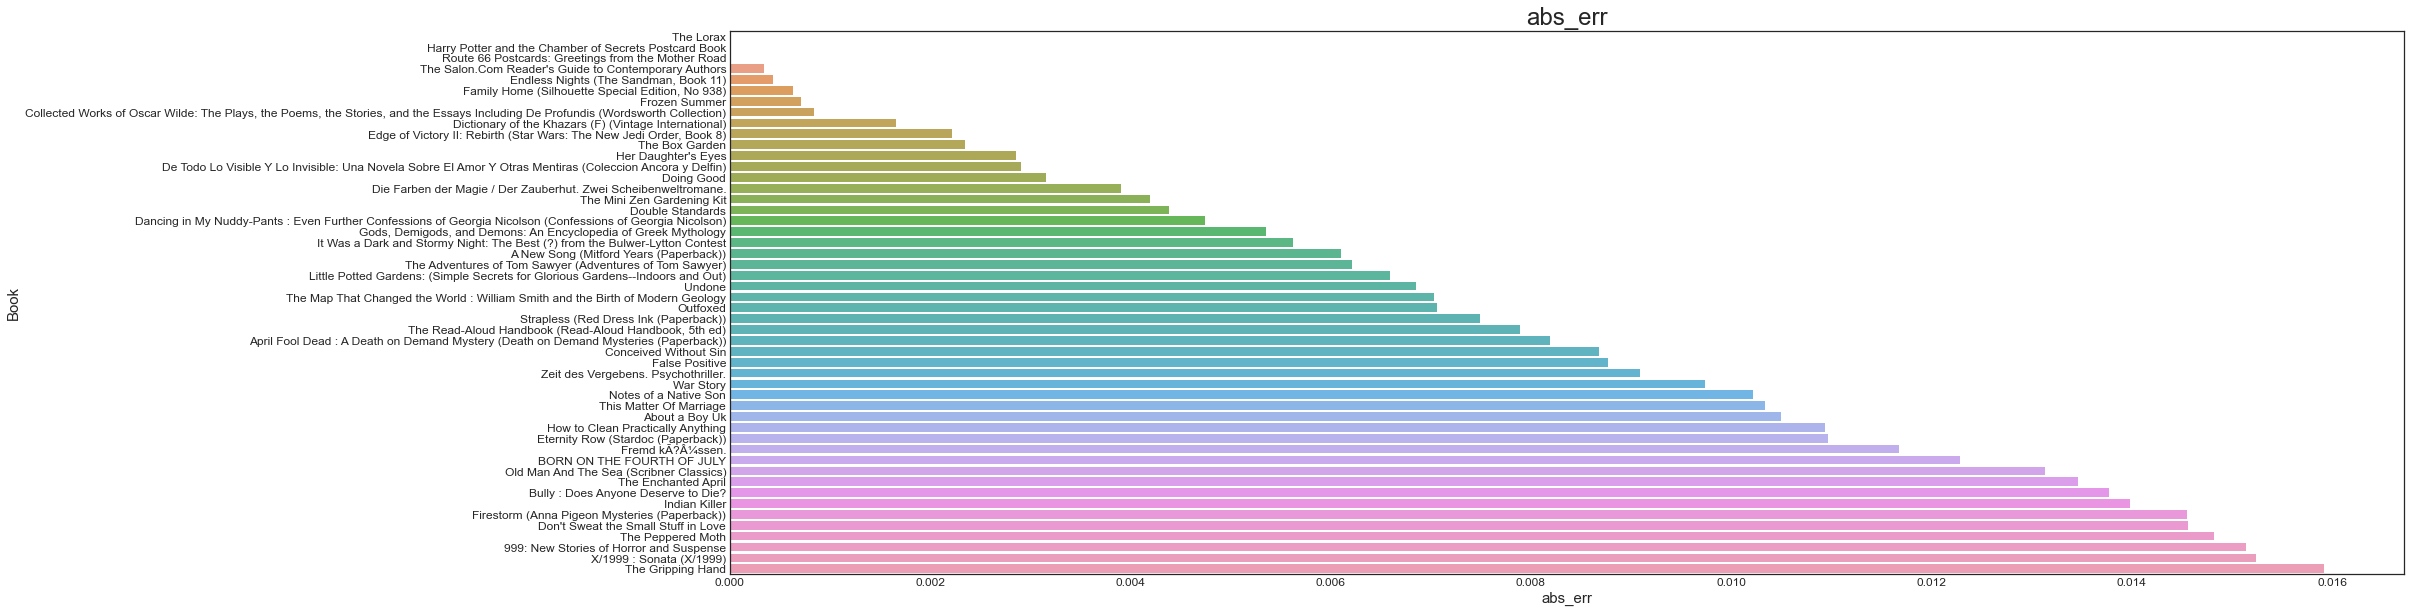

In [110]:
# 50 Books with the loest mean error in prediction 
df_Cou_err = df_ext.groupby('Book_title')['abs_err'].mean().reset_index()
df_Cou_err  = df_Cou_err.sort_values('abs_err', ascending=True)[:50]
plt.figure(figsize=(30,10))
sns.barplot(df_Cou_err['abs_err'], df_Cou_err['Book_title'], alpha=0.9)
plt.title('abs_err')
plt.ylabel('Book', fontsize=15)
plt.xlabel('abs_err', fontsize=15)
plt.tick_params(labelsize=12, rotation=0 )
plt.show()

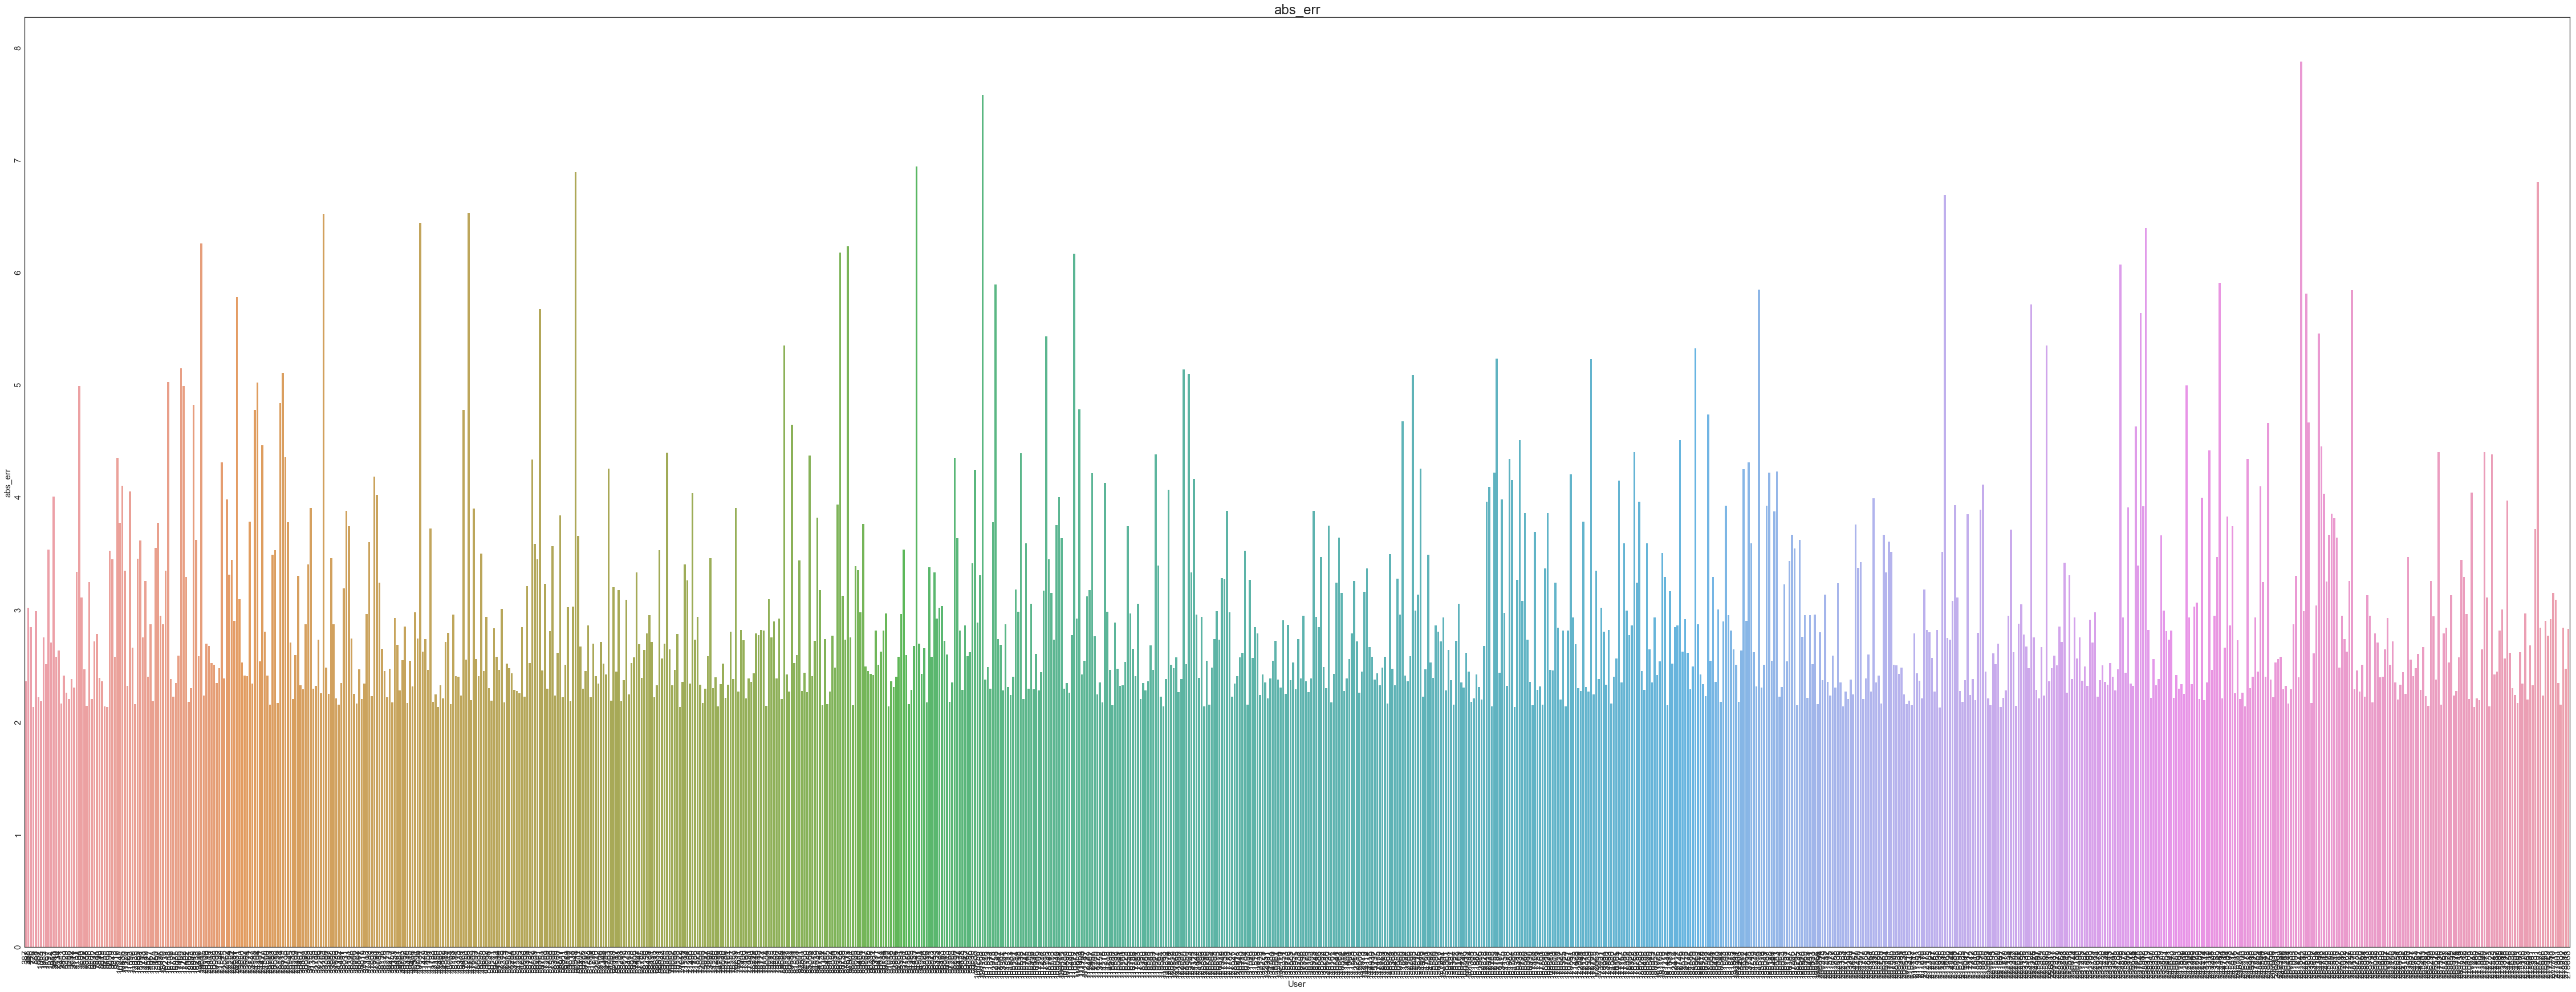

In [111]:
# 100 Users with the highest mean error in prediction 
df_Cou_err = df_ext.groupby('User_id')['abs_err'].mean().reset_index()
df_Cou_err  = df_Cou_err.sort_values('abs_err', ascending=False)[:1000]
plt.figure(figsize=(80,30))
sns.barplot(df_Cou_err['User_id'],df_Cou_err['abs_err'],  alpha=0.9)
plt.title('abs_err')
plt.ylabel('abs_err', fontsize=15)
plt.xlabel('User', fontsize=15)
plt.tick_params(labelsize=15, rotation=90 )
plt.show()

## Analysis and validation for User_ID 235105

We selected a random user to check the recmonede books for him against what was recommended actually by him

In [195]:
# Building the user profile for ratings more than 8
selected_user_id = 227250
df_user = df_ext[df_ext['User_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['Rating']>=9)].sample(20)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating,abs_err
136161,227250,0440236525,10,The Highlander's Touch,Karen Marie Moning,2000.0,Dell Publishing Company,32.0,rhame,north dakota,usa,NaN,NaN
136103,227250,0373691300,9,American Heroes: Riley,Lori Foster,2003.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136128,227250,0373790589,10,"Wild And Willing (Harlequin Blaze, No. 54)",Joanne Rock,2002.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136105,227250,0373764049,10,"Hide - And - Sheikh (Silhouette Desire, No. 1404)",Gail Dayton,2001.0,Silhouette,32.0,rhame,north dakota,usa,NaN,NaN
136119,227250,0373790457,10,"Seduced By The Enemy (Blaze, 41)",Jamie Denton,2002.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136118,227250,037379035X,10,"BODY CONTACT (Blaze, 31)",Rebecca York,2002.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136114,227250,0373790252,10,"Acting On Impulse (Midnight Fantasies) (Blaze,...",Vicki Lewis Thompson,2002.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136149,227250,037379097X,10,"Friendly Persuasion (Blaze, Book 93)",Dawn Atkins,2003.0,Harlequin,32.0,rhame,north dakota,usa,NaN,NaN
136165,227250,0515128007,10,The Morning After,Suzanne Forster,2000.0,Jove Books,32.0,rhame,north dakota,usa,NaN,NaN
136160,227250,0440234808,10,Beyond the Highland Mist,KAREN MARIE MONING,1999.0,Dell,32.0,rhame,north dakota,usa,NaN,NaN


In [196]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(12)


,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating,abs_err
136150,227250,0373790988,10,Slippery When Wet: Under the Covers (Harlequin...,Kristin Hardy,2003.0,Harlequin,32.0,rhame,north dakota,usa,9.174878,0.825122
136115,227250,0373790279,10,"Scent Of A Woman (Blaze, 23)",Jo Leigh,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.066688,0.933312
136129,227250,0373790597,10,Improper Conduct: Chicago Heat (Harlequin Blaz...,Patricia Rosemoor,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.052888,0.947112
136138,227250,0373790732,10,Against the Odds,Donna Kauffman,2003.0,Harlequin,32.0,rhame,north dakota,usa,9.039351,0.960649
136120,227250,0373790465,10,"One-Night Man (Blaze, 42)",Jeanie London,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.024474,0.975526
136134,227250,0373790694,10,"Fire and Ice: Legal Briefs (Harlequin Blaze, N...",Tori Carrington,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.964923,1.035077
136172,227250,0843948264,10,The Wild One: Secret Fires,Elaine Barbieri,2001.0,Leisure Books,32.0,rhame,north dakota,usa,8.959097,1.040903
136096,227250,0373272960,8,Private Maneuvers (Wingman Warriors),Catherine Mann,2003.0,Silhouette,32.0,rhame,north dakota,usa,8.953363,0.953363
136117,227250,0373790341,10,A TOUCH OF SILK - THE BACHELORS OF BEAR CREEK ...,Lori Wilde,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.942292,1.057708
136123,227250,0373790503,10,"His Private Pleasure (Blaze, 46)",Donna Kauffman,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.578252,1.421748


In [197]:
df_user[df_user['pred_rating'].notna()].sort_values('Rating', ascending=False).head(12)


,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating,abs_err
136106,227250,0373764170,10,Playboy Sheikh (Man Of The Month/Sons Of The D...,Alexandra Sellers,2002.0,Silhouette,32.0,rhame,north dakota,usa,8.505898,1.494102
136115,227250,0373790279,10,"Scent Of A Woman (Blaze, 23)",Jo Leigh,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.066688,0.933312
136117,227250,0373790341,10,A TOUCH OF SILK - THE BACHELORS OF BEAR CREEK ...,Lori Wilde,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.942292,1.057708
136120,227250,0373790465,10,"One-Night Man (Blaze, 42)",Jeanie London,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.024474,0.975526
136123,227250,0373790503,10,"His Private Pleasure (Blaze, 46)",Donna Kauffman,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.578252,1.421748
136129,227250,0373790597,10,Improper Conduct: Chicago Heat (Harlequin Blaz...,Patricia Rosemoor,2002.0,Harlequin,32.0,rhame,north dakota,usa,9.052888,0.947112
136134,227250,0373790694,10,"Fire and Ice: Legal Briefs (Harlequin Blaze, N...",Tori Carrington,2002.0,Harlequin,32.0,rhame,north dakota,usa,8.964923,1.035077
136138,227250,0373790732,10,Against the Odds,Donna Kauffman,2003.0,Harlequin,32.0,rhame,north dakota,usa,9.039351,0.960649
136150,227250,0373790988,10,Slippery When Wet: Under the Covers (Harlequin...,Kristin Hardy,2003.0,Harlequin,32.0,rhame,north dakota,usa,9.174878,0.825122
136172,227250,0843948264,10,The Wild One: Secret Fires,Elaine Barbieri,2001.0,Leisure Books,32.0,rhame,north dakota,usa,8.959097,1.040903


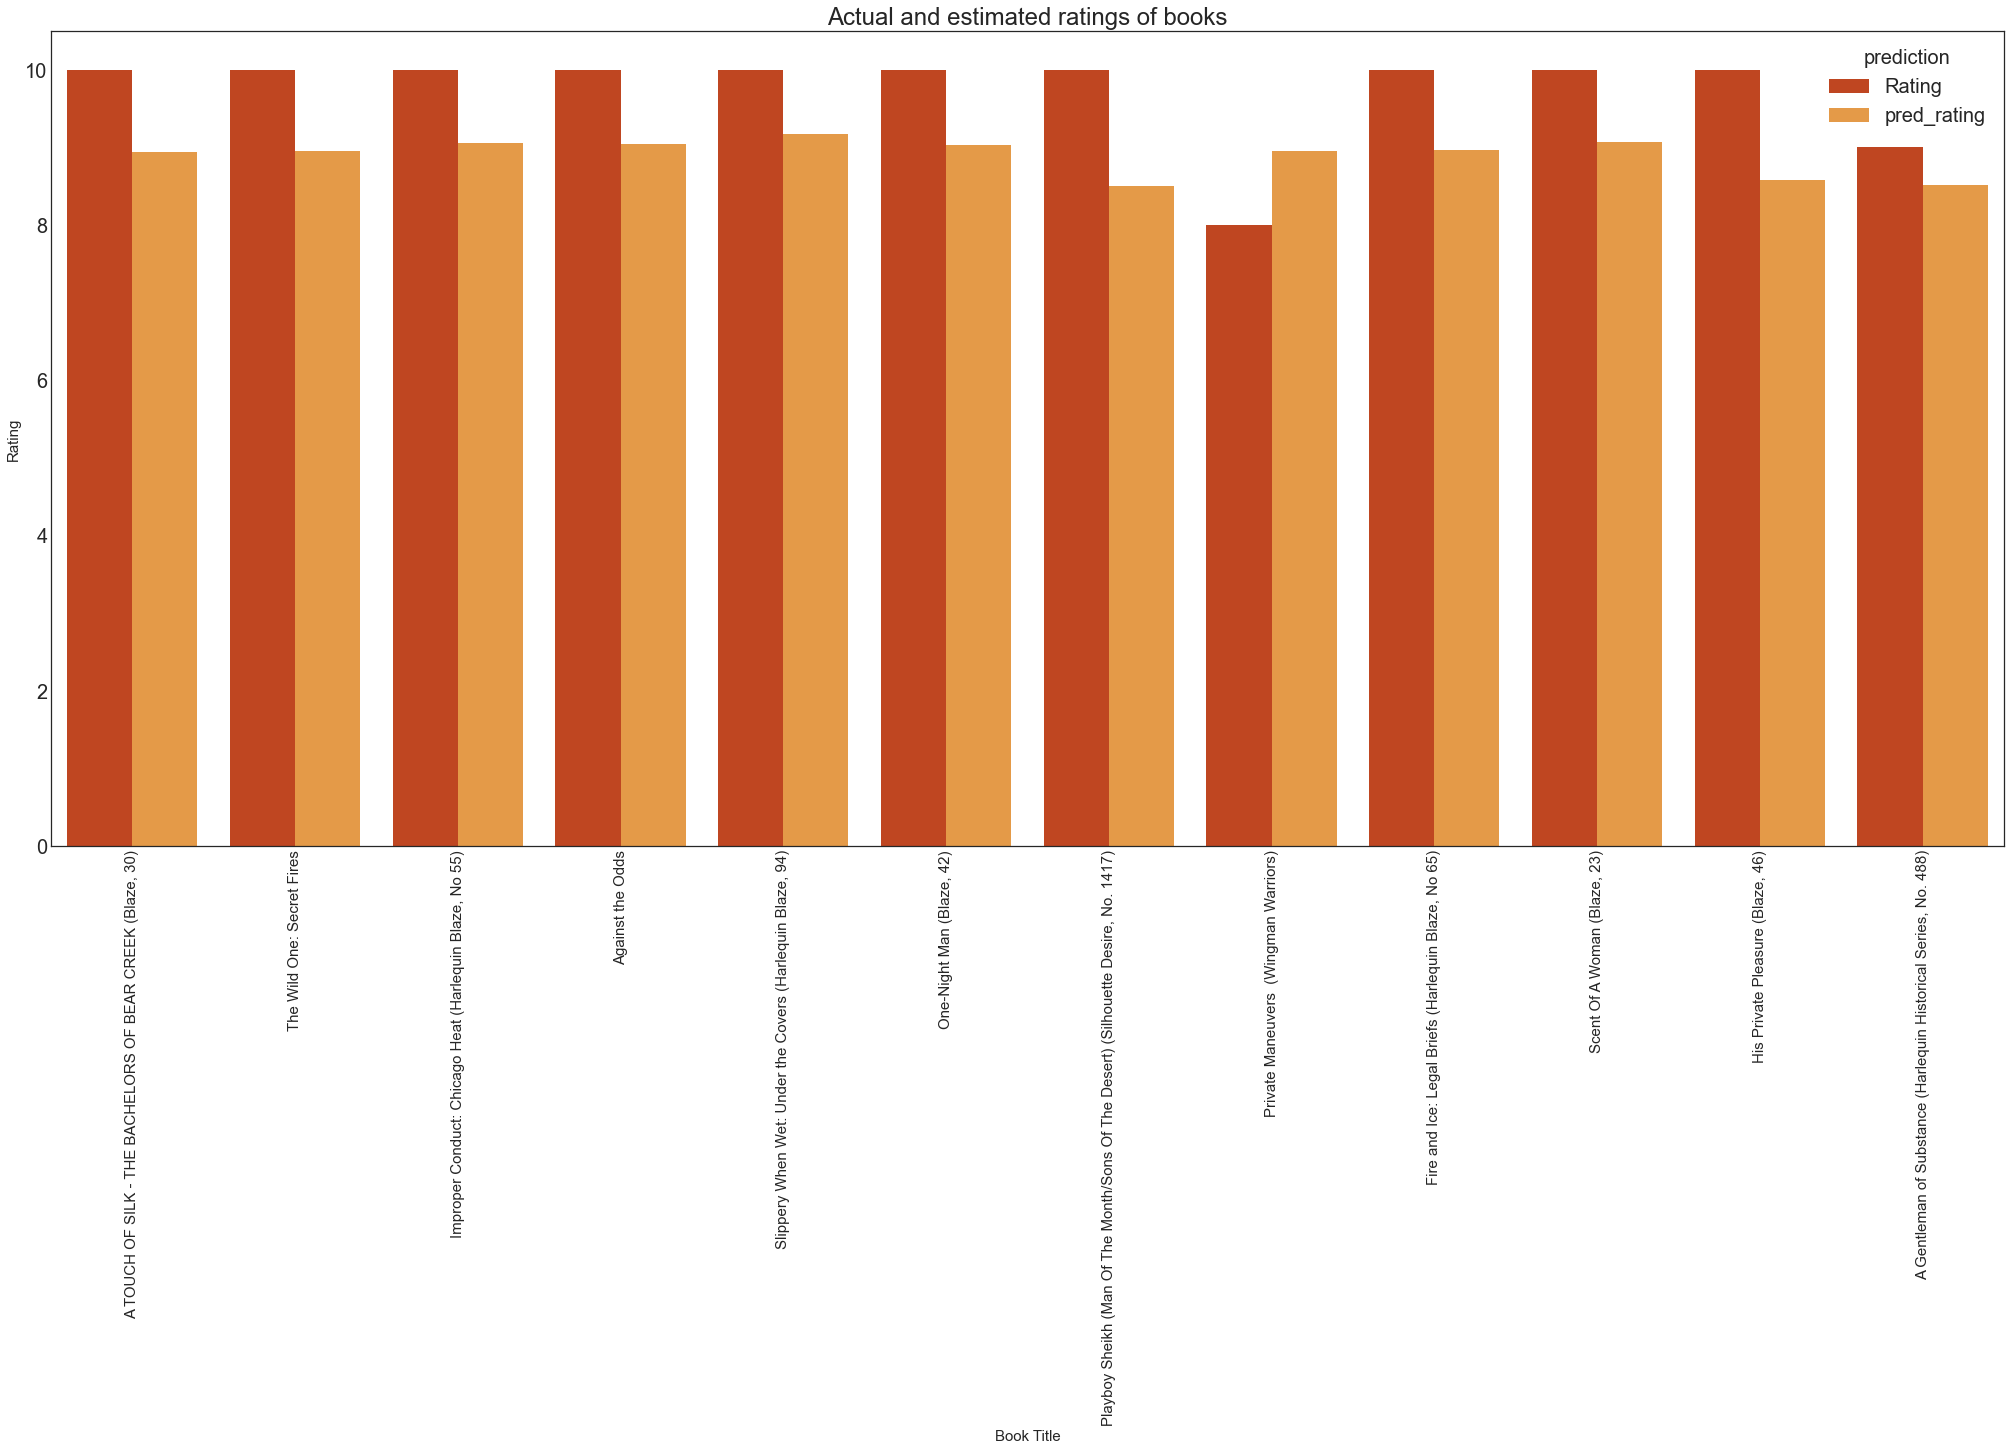

In [198]:

df_pred_sample = df_user[df_user['pred_rating'].notna()].sample(12)
df_pred_sample = pd.melt(df_pred_sample[['Book_title', 'Rating', 'pred_rating']], id_vars='Book_title', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(35, 15))

sns.barplot(x='Book_title', y='rating', hue='prediction', data=df_pred_sample, palette=sns.color_palette("turbo_r"))
ax.set_title('Actual and estimated ratings of books')
plt.ylabel('Rating', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.xticks(rotation=90, fontsize=15)

plt.show()

The chart below highlights the actual and predicted ratings of the books. There is error between the rating of the books, However the result of the top 10 recomended books are similar for the user 10 books rated

In [ ]:
#Extraction of the model matrix with the data 
df_cle = pd.DataFrame(df_ext[['User_id','ISBN','Book_title','pred_rating']])

df_cle.to_csv('Books_clean.csv')

## Recomendation App
https://bookrecommender1.herokuapp.com/
    
Recommendation App is built to serve the marketing team to do life anallysis on the recmended books for the users. this can be deployed at a bookstore chain with users who has registed profiles or bookstore advisors who can filter the books and recomend similar books for users who has the same taste of registered users

### GitHub link
https://github.com/tamerhanna/Book-Crossing-
